# **Hack IMDb Rating**

## **Introduction**

Welcome to the Movie Data Analysis Project! This notebook is designed to take you through a comprehensive journey of exploring, analyzing, and understanding the intricate world of movies. Our primary goal is to uncover the factors that influence a movie's success, focusing on aspects such as revenue generation and IMDB ratings.

This notebook is structured to guide you through each step of the process, from data loading and cleaning to in-depth analysis. So, let's dive in and explore the fascinating world of movies through the lens of data science!



## **Research Questions**

1. *What factors contribute to a movie's success, and how do they interplay?*
   - Language and its role in reaching a wider audience
   - How movie genres have evolved over time
   - The correlation between box office success and ratings
   - Geographical patterns in movie ratings 
   - Movie runtime and link with average rating correlation
   - Impact of the movie era
   - Impact of number of votes in IMDb rating

2. *Is there a link between real-world events and a movie's success?*
   - Analysis of movie plots in relation to real-world events
   - Comparative study of event-based movies against other genres

3. *How does diversity and representation influence movie ratings?*
   - Gender diversity within film casts
   - The effect of ethnic diversity on a film's reception

4. *What impact do actors have on a film's rating?*
   - The role of actor having an oscar or an oscar nomination on the IMDb rating

5. *Can we develop a predictive model for movie ratings?*
   - Utilizing identified key parameters for prediction

To enrich our analysis, we will add the IMDb ratings dataset which is key to our analysis.

By addressing these questions with analytical methods, we aim to offer a comprehensive understanding of the factors influencing IMDb ratings.

## **Additional Dataset**

### **Dataset Overview**

### **CMU Movie Summary Corpus**

We begin by analysing data from the CMU Movie Summary Corpus. This collection includes several files:

- *character.metadata.csv:* Contains metadata information about movie characters.
- *movie.metadata.tsv:* Provides movie metadata such as title, genre, and release year.
- *name.cluster.txt:* Offers information related to name clustering.
- *plot_summaries.txt:* Contains summaries of movie plots.
- *tvtropes.cluster.txt:* Includes data on TV Tropes clustering.

### **IMDb Rating Dataset**

Our analysis integrates the IMDb rating dataset taken from [IMDb Datasets](https://datasets.imdbws.com). This dataset comprises two CSV files:

- *rating_id.csv:* Contains IMDb rating data.
- *name_id.csv:* Includes additional information about the movies (name, type, ...).

### **Events Dataset**

Supplementary data, generated by ChatGPT, is included in the analysis. This dataset captures the most significant events from 1820 to 2014 and is created using the code found in `generate_events.py`.

### **Oscar Dataset**

This dataset is a collection of data from The Academy Awards Database, containing the winners and nominees of the Oscars from 1927 to 2023. it is taken from [kaggle Oscars Dataset](https://www.kaggle.com/datasets/unanimad/the-oscar-award) 


---

In [1]:
#imports
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import statsmodels.formula.api as smf
import plotly.express as px
import plotly.subplots as ps
import json
import statsmodels.api as sm
import scipy.stats as stats
from wordcloud import WordCloud

# import helper.py
from scripts.helper import *
from scripts.genre_label_helpers import *
from scripts.regression_loader_helpers import *
import scripts.regression_helpers as regression
from scripts.pair_matching_helper import * 

# plot settings
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set_palette("Set2")
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelweight'] = 'bold'
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

# **Data Pipeline**

#### **1. Loading CMU Data**

We define the `cmu_data_folder` constant to store the path to the CMU Movie Summary Corpus data folder. We then load the data from the different files into pandas dataframes.

In [2]:
cmu_data_folder = 'data/CMU_DATA/'

We define the `movie_metadata_df` dataframe, which contains information about the movies, such as title, box office revenue, movie runtime, genre, and release year.

In [3]:
#read tsv file and add headers
movie_metadata_df = pd.read_csv(cmu_data_folder + 'movie.metadata.tsv', sep='\t', header=None, 
                names=['wiki_movie_id', 
                        'freebase_movie_id', 
                        'movie_name', 
                        'movie_release_date', 
                        'movie_box_office_revenue', 
                        'movie_runtime', 
                        'movie_languages', 
                        'movie_countries', 
                        'movie_genres'])

#changing the values of outliers
movie_metadata_df.loc[movie_metadata_df['movie_name'] == 'Zero Tolerance', 'movie_runtime'] = 88
movie_metadata_df.loc[movie_metadata_df['movie_name'] == 'Hunting Season', 'movie_release_date'] = '2010-12-02'

#add realase_year
movie_metadata_df['movie_release_year'] = \
        movie_metadata_df['movie_release_date'].str[:4].astype(float)

print("Size of the movie_metadata_df:", movie_metadata_df.shape)
movie_metadata_df.sample(5)

Size of the movie_metadata_df: (81741, 10)


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year
70014,12489566,/m/02w8q9b,Seven Guns to Mesa,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0hfjk"": ""Western...",NaN
32783,23092502,/m/064m72p,Autumn Ball,2007,NaN,123.0,"{""/m/02s2l"": ""Estonian Language""}","{""/m/02kmm"": ""Estonia""}","{""/m/01t_vv"": ""Comedy-drama"", ""/m/0q9mp"": ""Tra...",2007.0
25107,23687447,/m/06zpbjz,Appunti su un fatto di cronaca,1951,NaN,NaN,"{""/m/02bjrlw"": ""Italian Language""}","{""/m/03rjj"": ""Italy""}","{""/m/02hmvc"": ""Short Film"", ""/m/0jtdp"": ""Docum...",1951.0
5946,3238135,/m/090glv,House of the Dead,2003-10-10,13818181.0,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""...",2003.0
38129,7253610,/m/0kv224,Won by Wireless,1911-07-14,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/02hmvc"": ""Short ...",1911.0


We define the `plot_summaries_df` dataframe, which contains summaries of movie plots.

In [4]:
#loading the plot summaries dataset and add headers
plot_summaries_df = pd.read_csv(cmu_data_folder + 'plot_summaries.txt', sep='\t', 
                                header=None, 
                                names=['wiki_movie_id', 'plot_summary'])

print("Size of the plot_summaries_df:", plot_summaries_df.shape)
plot_summaries_df.sample(5)

Size of the plot_summaries_df: (42303, 2)


,wiki_movie_id,plot_summary
1531,3018980,"Jayakrishnan , a well-to-do bachelor lives a c..."
15680,14076924,"In an isolated farmhouse, a woman named Doroth..."
25886,27691005,Antonciño is a poor man. He is planning a tra...
21285,31833243,While Wilbur Todd is content with his middle ...
1792,33415231,"The action takes place at Point Close station,..."


We define the `character_metadata_df` dataframe, which contains metadata information about movie characters and actors.

In [5]:
#read text file and add headers
character_metadata_df = pd.read_csv(cmu_data_folder + 'character.metadata.tsv', sep='\t', 
                                    header=None, 
                                    names=['wiki_movie_id',
                                    'freebase_movie_id',
                                    'movie_release_date',
                                    'character_name',
                                    'actor_date_of_birth',
                                    'actor_gender',
                                    'actor_height',
                                    'actor_ethnicity',
                                    'actor_name',
                                    'actor_age_at_movie_release',
                                    'freebase_character_actor_map_id',
                                    'freebase_character_id',
                                    'freebase_actor_id'])

# add movie_release_year
character_metadata_df['movie_release_year'] = \
    character_metadata_df['movie_release_date'].str[:4].astype(float)

print("Size of the character_metadata_df:", character_metadata_df.shape)
character_metadata_df.sample(5)

Size of the character_metadata_df: (450669, 14)


,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,movie_release_year
314243,16647845,/m/03yjj8z,2004,NaN,1958-07-30,M,1.867,NaN,Richard Burgi,45.0,/m/0cg7b33,NaN,/m/081x8w,2004.0
90499,702117,/m/0340hj,2007-04-16,Miss Brant,1974-02-10,F,1.650,NaN,Elizabeth Banks,33.0,/m/02h7x1x,/m/02nwmjf,/m/0716t2,2007.0
196552,6795057,/m/0gp97n,2003,NaN,1989,F,NaN,NaN,Reshma,13.0,/m/02tbg1g,NaN,/m/0dmkjr,2003.0
334850,8088101,/m/026q_d7,1940-03-15,NaN,1912-07-22,F,NaN,NaN,Luana Walters,27.0,/m/02vbygw,NaN,/m/02864dp,1940.0
155653,4118336,/m/0bk2ql,2005,Kago,1950-04-13,M,1.850,/m/041rx,Ron Perlman,54.0,/m/0k432g,/m/0h1jlvl,/m/03hhd3,2005.0


#### **2. Loading IMDB Data**

We define the `imdb_data_folder` constant to store the path to the IMDB rating dataset folder. We then load the data from the different files into pandas dataframes.

In [6]:
imdb_data_folder = 'data/IMDB_DATA/'

We define the `imdb_ratings_df` dataframe, which contains IMDb rating data. We construct this dataframe by merging the `rating_id_df`, which contains the ratings, and the `name_id_df`, which contains additional information about the movies (name, type, ...).

In [7]:
#load IMDB reviews
rating_id_df = pd.read_csv(imdb_data_folder + 'rating_id.tsv', sep='\t')
name_id_df = pd.read_csv(imdb_data_folder + 'name_id.tsv', sep='\t', 
                         usecols=['tconst', 'titleType', 'movie_name', 'startYear'])

# define '\N' as NaN
name_id_df = name_id_df.replace('\\N', np.nan)

# change startYear to float
name_id_df['startYear'] = name_id_df['startYear'].astype(float)

# merge rating_id_df and name_id_df
imdb_rating_df = pd.merge(rating_id_df, name_id_df, on='tconst', how='inner')

print("Size of the imdb_rating_df:", imdb_rating_df.shape)
imdb_rating_df.sample(5)

Size of the imdb_rating_df: (1368573, 6)


,tconst,averageRating,numVotes,titleType,movie_name,startYear
1152520,tt5322776,1.7,41,tvMovie,Children for Sale: The Fight to End Human Traf...,2014.0
923365,tt2373695,10.0,11,tvEpisode,Ice,2012.0
919625,tt2357553,7.7,1644,tvEpisode,Five Short Graybles,2012.0
830879,tt19465852,9.7,11,tvEpisode,Episode #2.1,2022.0
337133,tt0655442,7.3,501,tvEpisode,Racket Girls,1994.0


#### **3. Loading Events Data**

We define the `generated_data_folder` constant to store the path to the generated data folder. We then load the events into a pandas dataframe.

In [8]:
generated_data_folder = "data/GENERATED_DATA/"

We define the `events_df` dataframe, which contains the most significant events from 1820 to 2014.

In [9]:
#loading the events dataset
events_df = pd.read_csv(generated_data_folder + 'events.csv')

print("Size of the events_df:", events_df.shape)
events_df.sample(5)

Size of the events_df: (1902, 5)


,Year,Event Name,Event Description,Event Location,Event Category
265,1847,Smithsonian Institution Established,"The Smithsonian Institution, a group of museum...",US,Science and health advancement
1444,1966,Outbreak of Cholera in Portugal,A major cholera outbreak occurred in Portugal ...,PT,Science and health advancement
240,1845,Florida Statehood,Florida became the 27th U.S. state on March 3r...,US,Political Events
653,1884,First Performance of 'Amleto',"Franco Faccio's opera, 'Amleto', premièred at ...",IT,Cultural Events
1124,1933,Repeal of the Gold Standard,"In an effort to combat the Great Depression, P...",US,Economic Events


#### **4. Loading Oscars Data**

We define the `oscars_data_folder` constant to store the path to the Oscars dataset folder. We then load the oscars data into a pandas dataframe.

In [10]:
oscars_data_folder = "data/OSCAR_DATASET/"

We define the `oscar_nominees_df` dataframe, which contains the winners and nominees of the Oscars from 1927 to 2016.

In [11]:
# read the oscar dataset
oscar_nominees_df = pd.read_csv(oscars_data_folder + 'the_oscar_award.csv')
# drop the ceremonies after 2016
oscar_nominees_df = oscar_nominees_df[oscar_nominees_df['year_ceremony'] < 2017]
# add a column for the number of nominations per category
oscar_nominees_df['nomination_count'] = \
    oscar_nominees_df.groupby(['year_ceremony', 'category'])['name'].transform('count')
# add a column for the number of wins per category
oscar_nominees_df['win_count'] = \
    oscar_nominees_df.groupby(['year_ceremony', 'category'])['winner'].transform('sum')

print("Size of the oscar_nominees_df:", oscar_nominees_df.shape)
oscar_nominees_df.sample(5)

Size of the oscar_nominees_df: (9889, 9)


,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
2920,1954,1955,27,CINEMATOGRAPHY (Color),Leon Shamroy,The Egyptian,False,5,1
1127,1941,1942,14,CINEMATOGRAPHY (Black-and-White),Arthur Miller,How Green Was My Valley,True,10,1
8977,2008,2009,81,MUSIC (Original Song),Music and Lyric by A.R. Rahman and Maya Arulpr...,Slumdog Millionaire,False,3,1
8819,2007,2008,80,CINEMATOGRAPHY,Roger Deakins,The Assassination of Jesse James by the Coward...,False,5,1
2554,1951,1952,24,COSTUME DESIGN (Color),"Orry-Kelly, Walter Plunkett, Irene Sharaff",An American in Paris,True,5,1


We define the `oscar_winners_df` dataframe, which contains the winners of the Oscars from 1927 to 2016.

In [12]:
# filter the oscar dataset to only include winners
oscar_winners_df = oscar_nominees_df[oscar_nominees_df['winner'] == True]
oscar_winners_df = oscar_winners_df.drop(columns=['winner'])

print("Size of the oscar_winners_df:", oscar_winners_df.shape)
oscar_winners_df.sample(5)

Size of the oscar_winners_df: (2244, 8)


,year_film,year_ceremony,ceremony,category,name,film,nomination_count,win_count
2032,1946,1947,19,SHORT SUBJECT (Cartoon),"Frederick Quimby, Producer",The Cat Concerto,5,1
5228,1974,1975,47,DIRECTING,Francis Ford Coppola,The Godfather Part II,5,1
2626,1951,1952,24,IRVING G. THALBERG MEMORIAL AWARD,Arthur Freed,NaN,1,1
2721,1952,1953,25,SHORT SUBJECT (One-reel),"Boris Vermont, Producer",Light in the Window: The Art of Vermeer,5,1
2612,1951,1952,24,WRITING (Motion Picture Story),"Paul Dehn, James Bernard",Seven Days to Noon,5,1


In [13]:
# get the unique categories of the award
oscar_award_categories_df = pd.DataFrame(oscar_nominees_df['category'].unique())
oscar_award_categories_df.columns = ['category']
oscar_award_categories_df.sort_values(by=['category'], inplace=True, ignore_index=True)
oscar_award_categories_df.head()

,category
0,ACTOR
1,ACTOR IN A LEADING ROLE
2,ACTOR IN A SUPPORTING ROLE
3,ACTRESS
4,ACTRESS IN A LEADING ROLE


We define the `actor_nominees_df` dataframe, wich contains the actors who were nominated for the Oscars from 1927 to 2016.

In [14]:
# identify the categories that are related to actors
actor_reward_names = ['ACTOR', 
                      'ACTRESS', 
                      'ACTOR IN A LEADING ROLE', 
                      'ACTRESS IN A LEADING ROLE', 
                      'ACTOR IN A SUPPORTING ROLE', 
                      'ACTRESS IN A SUPPORTING ROLE']

actor_nominees_df = \
    oscar_nominees_df[oscar_nominees_df['category'].isin(actor_reward_names)]

print("Size of the actor_nominees_df:", actor_nominees_df.shape)
actor_nominees_df.sample(5)

Size of the actor_nominees_df: (1668, 9)


,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
6907,1990,1991,63,ACTRESS IN A SUPPORTING ROLE,Diane Ladd,Wild at Heart,False,5,1
8244,2002,2003,75,ACTRESS IN A SUPPORTING ROLE,Julianne Moore,The Hours,False,5,1
3377,1958,1959,31,ACTRESS IN A SUPPORTING ROLE,Peggy Cass,Auntie Mame,False,5,1
5622,1978,1979,51,ACTOR IN A LEADING ROLE,Jon Voight,Coming Home,True,5,1
8804,2007,2008,80,ACTRESS IN A LEADING ROLE,Laura Linney,The Savages,False,5,1


We define the `actor_winning_df` dataframe, wich contains the actors who won the Oscars from 1927 to 2016.

In [15]:
# filter to only include winners
actor_winning_df = actor_nominees_df[actor_nominees_df['winner'] == True]
actor_winning_df = actor_winning_df.drop(columns=['winner'])

print("Size of the actor_winning_df:", actor_winning_df.shape)
actor_winning_df.sample(5)

Size of the actor_winning_df: (338, 8)


,year_film,year_ceremony,ceremony,category,name,film,nomination_count,win_count
4331,1966,1967,39,ACTOR,Paul Scofield,A Man for All Seasons,5,1
4685,1969,1970,42,ACTRESS IN A SUPPORTING ROLE,Goldie Hawn,Cactus Flower,5,1
8907,2008,2009,81,ACTOR IN A LEADING ROLE,Sean Penn,Milk,5,1
5413,1976,1977,49,ACTOR IN A SUPPORTING ROLE,Jason Robards,All the President's Men,5,1
434,1936,1937,9,ACTRESS IN A SUPPORTING ROLE,Gale Sondergaard,Anthony Adverse,5,1


We define the `best_movie_nominees_df` dataframe, wich contains the movies that were nominated for the Oscars from 1927 to 2016.

In [16]:
# identify the categories that are related to movies
best_movie_reward_names = ['OUTSTANDING PICTURE',
                           'OUTSTANDING PRODUCTION',
                           'OUTSTANDING MOTION PICTURE',
                           'BEST MOTION PICTURE',
                           'BEST PICTURE']

best_movie_nominees_df = \
    oscar_nominees_df[oscar_nominees_df['category'].isin(best_movie_reward_names)]

print("Size of the best_movie_nominees_df:", best_movie_nominees_df.shape)
best_movie_nominees_df.sample(5)

Size of the best_movie_nominees_df: (528, 9)


,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
9590,2013,2014,86,BEST PICTURE,"Alfonso Cuarón and David Heyman, Producers",Gravity,False,9,1
7070,1991,1992,64,BEST PICTURE,"Don Hahn, Producer",Beauty and the Beast,False,5,1
2246,1948,1949,21,BEST MOTION PICTURE,20th Century-Fox,The Snake Pit,False,5,1
7290,1993,1994,66,BEST PICTURE,"Mike Nichols, John Calley and Ismail Merchant,...",The Remains of the Day,False,5,1
296,1934,1935,7,OUTSTANDING PRODUCTION,First National,Flirtation Walk,False,12,1


We define the `best_movie_winners_df` dataframe, wich contains the movies that won the Oscars from 1927 to 2016.

In [17]:
# filter to only include winners
movie_winning_df = best_movie_nominees_df[best_movie_nominees_df['winner'] == True]
movie_winning_df = movie_winning_df.drop(columns=['winner'])

print("Size of the movie_winning_df:", movie_winning_df.shape)
movie_winning_df.sample(5)

Size of the movie_winning_df: (88, 8)


,year_film,year_ceremony,ceremony,category,name,film,nomination_count,win_count
5692,1978,1979,51,BEST PICTURE,"Barry Spikings, Michael Deeley, Michael Cimino...",The Deer Hunter,5,1
7750,1997,1998,70,BEST PICTURE,"James Cameron and Jon Landau, Producers",Titanic,5,1
21,1927,1928,1,OUTSTANDING PICTURE,Paramount Famous Lasky,Wings,3,1
5481,1976,1977,49,BEST PICTURE,"Irwin Winkler and Robert Chartoff, Producers",Rocky,5,1
3444,1958,1959,31,BEST MOTION PICTURE,"Arthur Freed, Producer",Gigi,5,1


#### **5. Merging The Movie Metadata With The IMDb Ratings**

We define the `movie_metadata_ratings_df` dataframe, which contains the movie metadata and the IMDb ratings. We construct this dataframe by merging the `movie_metadata_df` dataframe and the `imdb_ratings_df` dataframe.

In [18]:
#merging the movie metadata with the rating data on movie name and release year
movie_metadata_rating_df = pd.merge(movie_metadata_df, 
                                    imdb_rating_df, 
                                    how='inner',
                                    left_on=['movie_name', 'movie_release_year'], 
                                    right_on=['movie_name', 'startYear'])

#drop startYear column
movie_metadata_rating_df = movie_metadata_rating_df.drop(columns=['startYear'])

print("Size of the movie_metadata_rating_df:", movie_metadata_rating_df.shape)
movie_metadata_rating_df.sample(5)

Size of the movie_metadata_rating_df: (51108, 14)


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,tconst,averageRating,numVotes,titleType
50746,19284029,/m/04lf3fs,Mon Amour: Shesher Kobita Revisited,2008-08-08,NaN,135.0,"{""/m/01c7y"": ""Bengali Language""}","{""/m/03rk0"": ""India""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",...",2008.0,tt1408049,7.1,11,movie
37715,23270459,/m/0661ql3,Inception,2010-07-08,825532764.0,148.0,"{""/m/064_8sq"": ""French Language"", ""/m/03_9r"": ...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2010.0,tt1375666,8.8,2484507,movie
26677,10163440,/m/02q3wlz,Daisies,1966,NaN,75.0,"{""/m/01wgr"": ""Czech Language""}","{""/m/01mk6"": ""Czechoslovakia"", ""/m/01mjq"": ""Cz...","{""/m/03q4nz"": ""World cinema"", ""/m/0424mc"": ""Ex...",1966.0,tt0060959,7.3,14692,movie
37235,15886402,/m/03qdlh6,The Final Destination,2009-08-26,186167139.0,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/02b5_l"": ""Teen"",...",2009.0,tt1144884,5.1,112861,movie
42327,24007622,/m/07k9slf,Hobson's Choice,1931-10-02,NaN,65.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/05p553"": ""Comedy film"", ""/m/07s9rl0"": ""Dr...",1931.0,tt0021965,7.4,27,movie


#### **6. Merging The Movie Metadata With The Oscars Data**

We define the `movie_metadata_awards_df` dataframe, which contains the movie metadata and the Oscars data. We construct this dataframe by merging the `movie_metadata_df` dataframe and the `oscar_nominees_df` dataframe.

In [19]:
# merge character_metadata_award_df and best_picture_df
movie_metadata_award_df = pd.merge(movie_metadata_df, 
                                   best_movie_nominees_df, 
                                   how='right',
                                   left_on=['movie_name'], 
                                   right_on=['film'])

# keep only rows where either the movie_release_year is equal to the year_film 
# or the movie_release_year is equal to the year_ceremony else keep the movie_release_year is na
movie_metadata_award_df = \
    movie_metadata_award_df[(movie_metadata_award_df['movie_release_year'] == movie_metadata_award_df['year_film']) | 
                            (movie_metadata_award_df['movie_release_year'] == movie_metadata_award_df['year_ceremony']) |
                            (movie_metadata_award_df['movie_release_year'].isna())]

# extract the duplicate rows on the column 'film'
duplicateRowsDF = \
    movie_metadata_award_df[movie_metadata_award_df.duplicated(['film'], keep=False)]

# keep only the rows where the movie_release_year is na
duplicateRowsDF = duplicateRowsDF[duplicateRowsDF['movie_release_year'].isna()]

# drop rows that are in both duplicateRowsDF and movie_metadata_award_df
movie_metadata_award_df = movie_metadata_award_df.drop(duplicateRowsDF.index)

#add a column for nominated
movie_metadata_award_df['nominated'] = True

# sort by movie_release_date
movie_metadata_award_df = movie_metadata_award_df.sort_values(by=['year_film'])

print("Size of the movie_metadata_award_df:", movie_metadata_award_df.shape)
movie_metadata_award_df.sample(5)

Size of the movie_metadata_award_df: (504, 20)


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count,nominated
544,73425.0,/m/0jqj5,The Deer Hunter,1978-12-08,50000000.0,183.0,"{""/m/064_8sq"": ""French Language"", ""/m/07zrf"": ...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01fc50"": ""Anti-war"", ""/m/0hj3n0w"": ""Ensem...",1978.0,1978,1979,51,BEST PICTURE,"Barry Spikings, Michael Deeley, Michael Cimino...",The Deer Hunter,True,5,1,True
737,15161999.0,/m/03hkch7,Milk,2008-10-28,54501383.0,128.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hn10"": ""LGBT"", ""/m/0fx2s"": ""Tragedy"", ""/...",2008.0,2008,2009,81,BEST PICTURE,"Dan Jinks and Bruce Cohen, Producers",Milk,False,5,1,True
238,18936071.0,/m/04jgclj,The Human Comedy,1943-03-02,NaN,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...",1943.0,1943,1944,16,OUTSTANDING MOTION PICTURE,Metro-Goldwyn-Mayer,The Human Comedy,False,10,1,True
754,23810915.0,/m/06_x996,Up in the Air,2009-09-05,166842739.0,108.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/01t_vv"": ""...",2009.0,2009,2010,82,BEST PICTURE,"Daniel Dubiecki, Ivan Reitman and Jason Reitma...",Up in the Air,False,10,1,True
712,1045457.0,/m/04165w,Finding Neverland,2004-09-04,118676606.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/017fp"": ""Biography"", ""/m/04xvh5"": ""Costum...",2004.0,2004,2005,77,BEST PICTURE,"Richard N. Gladstein and Nellie Bellflower, Pr...",Finding Neverland,False,5,1,True


#### **7. Merging The Character Metadata With The Oscars Data**

We define the `character_metadata_awards_df` dataframe, which contains the character metadata and the Oscars data. We construct this dataframe by merging the `character_metadata_df` dataframe and the `oscar_nominees_df` dataframe.

In [20]:
# add the movie name to the character metadata
temp_character_df = pd.merge(character_metadata_df, 
                             movie_metadata_df[['wiki_movie_id', 'movie_name']], 
                             on='wiki_movie_id', 
                             how='left')

# merge character_metadata_df and actor_actress_df
character_metadata_award_df = pd.merge(temp_character_df, actor_nominees_df, 
                                 how='inner',
                                 left_on=['actor_name', 'movie_name'], 
                                 right_on=['name', 'film'])

# keep only rows where movie_release_year and year_film  or movie_release_year and year_ceremony are equal
character_metadata_award_df = \
    character_metadata_award_df[(character_metadata_award_df['movie_release_year'] \
                                 == character_metadata_award_df['year_film']) | 
                                (character_metadata_award_df['movie_release_year'] \
                                 == character_metadata_award_df['year_ceremony'])]

# sort by year_film
character_metadata_award_df = \
    character_metadata_award_df.sort_values(by=['year_film'])

print("Size of the character_metadata_award_df:", character_metadata_award_df.shape)
character_metadata_award_df.sample(5)

Size of the character_metadata_award_df: (1452, 24)


,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,...,movie_name,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
1349,29454281,/m/0ds3t5x,2011-08-10,Aibileen Clark,1965-08-11,F,1.651,/m/0x67,Viola Davis,45.0,...,The Help,2011,2012,84,ACTRESS IN A LEADING ROLE,Viola Davis,The Help,False,5,1
627,101914,/m/0ptx_,1975,Sonny,1940-04-25,M,1.700,/m/0xnvg,Al Pacino,34.0,...,Dog Day Afternoon,1975,1976,48,ACTOR,Al Pacino,Dog Day Afternoon,False,5,1
1459,1623960,/m/05hjnw,2005-12-09,Alma,1980-09-09,F,1.630,NaN,Michelle Williams,25.0,...,Brokeback Mountain,2005,2006,78,ACTRESS IN A SUPPORTING ROLE,Michelle Williams,Brokeback Mountain,False,5,1
246,9309429,/m/0283_zv,1961-09-25,NaN,1927-10-18,M,1.850,/m/02ctzb,George C. Scott,33.0,...,The Hustler,1961,1962,34,ACTOR IN A SUPPORTING ROLE,George C. Scott,The Hustler,False,5,1
276,4717779,/m/0cjwhb,1954-08-04,Helen Phillips,1917-01-05,F,1.590,NaN,Jane Wyman,37.0,...,Magnificent Obsession,1954,1955,27,ACTRESS,Jane Wyman,Magnificent Obsession,False,5,1


#### **8. Merging The Movie Metadata With The IMDb Ratings and Oscars Data**

We define the `movie_metadata_ratings_awards_df` dataframe, which contains the movie metadata, the IMDb ratings, and the Oscars data. We construct this dataframe by merging the `movie_metadata_ratings_df` dataframe and the `oscar_nominees_df` dataframe.

In [21]:
# merge movie_metadata_rating_df and movie_metadata_award_df
movie_metadata_rating_award_df = pd.merge(movie_metadata_rating_df, 
                                          movie_metadata_award_df[['wiki_movie_id', 
                                                                   'movie_name', 
                                                                   'movie_release_year', 
                                                                   'ceremony', 
                                                                   'category', 
                                                                   'nominated', 
                                                                   'winner']], 
                                          how='left',
                                          on=['wiki_movie_id'])

# change na values in winner to False
movie_metadata_rating_award_df['winner'] = \
    movie_metadata_rating_award_df['winner'].fillna(False)

# change na values in nominated to False
movie_metadata_rating_award_df['nominated'] = \
    movie_metadata_rating_award_df['nominated'].fillna(False)

print("Size of the movie_metadata_rating_award_df:", movie_metadata_rating_award_df.shape)
movie_metadata_rating_award_df.sample(5)

Size of the movie_metadata_rating_award_df: (51108, 20)


,wiki_movie_id,freebase_movie_id,movie_name_x,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year_x,tconst,averageRating,numVotes,titleType,movie_name_y,movie_release_year_y,ceremony,category,nominated,winner
27074,34896646,/m/0j45mvk,Una gita scolastica,1983-08-31,NaN,90.0,"{""/m/02bjrlw"": ""Italian Language""}","{""/m/03rjj"": ""Italy""}","{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D...",1983.0,tt0085597,7.1,298,movie,NaN,NaN,NaN,NaN,False,False
27682,35854218,/m/0jwrhb9,The Sinister Man,1961,NaN,61.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My...",1961.0,tt0214130,6.0,46,tvEpisode,NaN,NaN,NaN,NaN,False,False
47085,27930352,/m/04j0dd8,The Lottery Bride,1930,NaN,80.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",1930.0,tt0021094,5.1,191,movie,NaN,NaN,NaN,NaN,False,False
34450,68084,/m/0hv32,Adam's Rib,1949,6000000.0,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",1949.0,tt0041090,7.4,22539,movie,NaN,NaN,NaN,NaN,False,False
29602,24569457,/m/080p8nj,August 32nd on Earth,1998-09-17,NaN,88.0,{},"{""/m/0d060g"": ""Canada""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/04228s"": ""...",1998.0,tt0156248,6.5,3338,movie,NaN,NaN,NaN,NaN,False,False


#### **9. Cleaning The Data**

After inspecting of the plot_summary file in the CMU dataset, we noticed that some movie plots contains undesired words such as ({long plot}, {plot}...). These outliers can degrade our plot analysis so we proceeded to remove them. 

In [22]:
#remove any {{ }} tag from the plot summary text
plot_summaries_df['plot_summary'] = \
    plot_summaries_df['plot_summary'].str.replace(r'\{\{.*?\}\}', '', regex=True)

We noticed the IMDb dataset included other types of movies, those movies are also in some cases present in the CMU dataset. Since our analysis focuses on movies we opted to only keep **'movie'** title type movies. 

In [23]:
# printing the types of the merged data
movie_metadata_rating_df['titleType'].unique().tolist()

['movie',
 'tvEpisode',
 'short',
 'tvMovie',
 'video',
 'tvSeries',
 'videoGame',
 'tvMiniSeries',
 'tvSpecial',
 'tvShort']

In [24]:
# keeping only movies, delete tv episodes, tv movies, video games, etc.
movie_metadata_rating_df = \
    movie_metadata_rating_df[movie_metadata_rating_df['titleType'] == 'movie']
movie_metadata_rating_award_df = \
    movie_metadata_rating_award_df[movie_metadata_rating_award_df['titleType'] == 'movie']

print("Size of the movie_metadata_rating_df:", movie_metadata_rating_df.shape)

Size of the movie_metadata_rating_df: (39963, 14)


We noticed that the IMDb dataset contains movie ratings that have few ratings so we thought that these ratings could be biased so we removed the movies that have less than 200 votes

In [25]:
# only keep the movies with more than 200 votes on imdb ratings
movies_metadata_rating_df = \
    movie_metadata_rating_df[movie_metadata_rating_df['numVotes'] > 200]
movies_metadata_rating_award_df = \
    movie_metadata_rating_award_df[movie_metadata_rating_award_df['numVotes'] > 200]

print("Size of the movies_metadata_rating_df:", movies_metadata_rating_df.shape)

Size of the movies_metadata_rating_df: (27739, 14)


Now we will filter the other datasets so that they are consistant

In [26]:
#keep movie_metadata_df only with movies that have ratings
movie_metadata_df = \
    movie_metadata_df[movie_metadata_df['freebase_movie_id'].isin(movies_metadata_rating_df['freebase_movie_id'])]

print("Size of the movie_metadata_df:", movie_metadata_df.shape)

Size of the movie_metadata_df: (27655, 10)


In [27]:
#keep the summaries of the selected movies 
plot_summaries_df = \
    plot_summaries_df[plot_summaries_df['wiki_movie_id'].isin(movie_metadata_df['wiki_movie_id'])]

print("Size of the plot_summaries_df:", plot_summaries_df.shape)

Size of the plot_summaries_df: (20161, 2)


In [28]:
#keep movie_metadata_df only with movies that have summaries
movie_metadata_df = \
    movie_metadata_df[movie_metadata_df['wiki_movie_id'].isin(plot_summaries_df['wiki_movie_id'])]

print("Size of the movie_metadata_df:", movie_metadata_df.shape)

Size of the movie_metadata_df: (20161, 10)


In [29]:
#keep movies_metadata_ratings only with movies that have summaries
movies_metadata_ratings_df = \
    movies_metadata_rating_df[movies_metadata_rating_df['wiki_movie_id'].isin(plot_summaries_df['wiki_movie_id'])]

print("Size of the movies_metadata_ratings_df:", movies_metadata_ratings_df.shape)

Size of the movies_metadata_ratings_df: (20216, 14)


In [30]:
#keep the character_metadata_df only with movies that have summaries and ratings
character_metadata_df = \
    character_metadata_df[character_metadata_df['wiki_movie_id'].isin(movie_metadata_df['wiki_movie_id'])]

print("Size of the character_metadata_df:", character_metadata_df.shape)

Size of the character_metadata_df: (192540, 14)


---

# **Data Analysis**

## **1. English Might Not Be Your Best Bet**

The language spoken in the movie would be an important point to consider, since this is the choice of auditory you're primarily going to envision. Hence, it would be interesting see how the presence of different languages in a movie affetcs its receptioin by the public. 
One might think that English is the best language to create a movie in order to achieve a high IMDb rating, as it is the most international language, reaching a wider audience and potentially increasing ratings. To explore the impact of language on IMDb ratings, we begin by plotting the median of ratings for each movie and th 95% confidence interval.

We define the `language_ratings_df` dataframe, which contains the language of a movie and its IMDb rating. We construct this dataframe by reading the `movie_languages` column from the `movie_metadata_ratings_df` dataframe. This column contains a dictionary of language_id and language_name. We then extract the language_name and add it to the a new column called `movie_language`.

In [31]:
languages_ratings_df = \
    movies_metadata_ratings_df[['wiki_movie_id', 
                                'movie_languages', 
                                'averageRating']]

languages_ratings_df['movie_languages'] = \
    languages_ratings_df['movie_languages'].apply(lambda x: list(json.loads(x).values()))

# Explode the 'movie_languages' column
languages_ratings_df = languages_ratings_df.explode('movie_languages')

# Rename the column and select only the required columns
languages_ratings_df = \
    languages_ratings_df.rename(columns={'movie_languages': 'language_name'})[['wiki_movie_id', 
                                                                               'language_name', 
                                                                               'averageRating']]

languages_ratings_df = \
    languages_ratings_df[languages_ratings_df['language_name'].notna()]
languages_ratings_df.reset_index(drop=True, inplace=True)

print("Size of the languages_ratings_df:", languages_ratings_df.shape)
languages_ratings_df.sample(5)

Size of the languages_ratings_df: (24339, 3)


,wiki_movie_id,language_name,averageRating
6788,8593082,English Language,6.3
22245,14719603,English Language,6.4
17401,24001036,Japanese Language,7.7
3049,919005,English Language,7.5
21776,54030,Spanish Language,6.9


First of all, lets's visualize the distribution of languages in our dataset. As the plot below shows us, english speeking films are prelevant, we have a few languages that are represented by a total of around 1000 samples each, meanwhile, the other languages have considerably fewer representatives. In the plot below, those under a certain threshold are reperesented as "others"

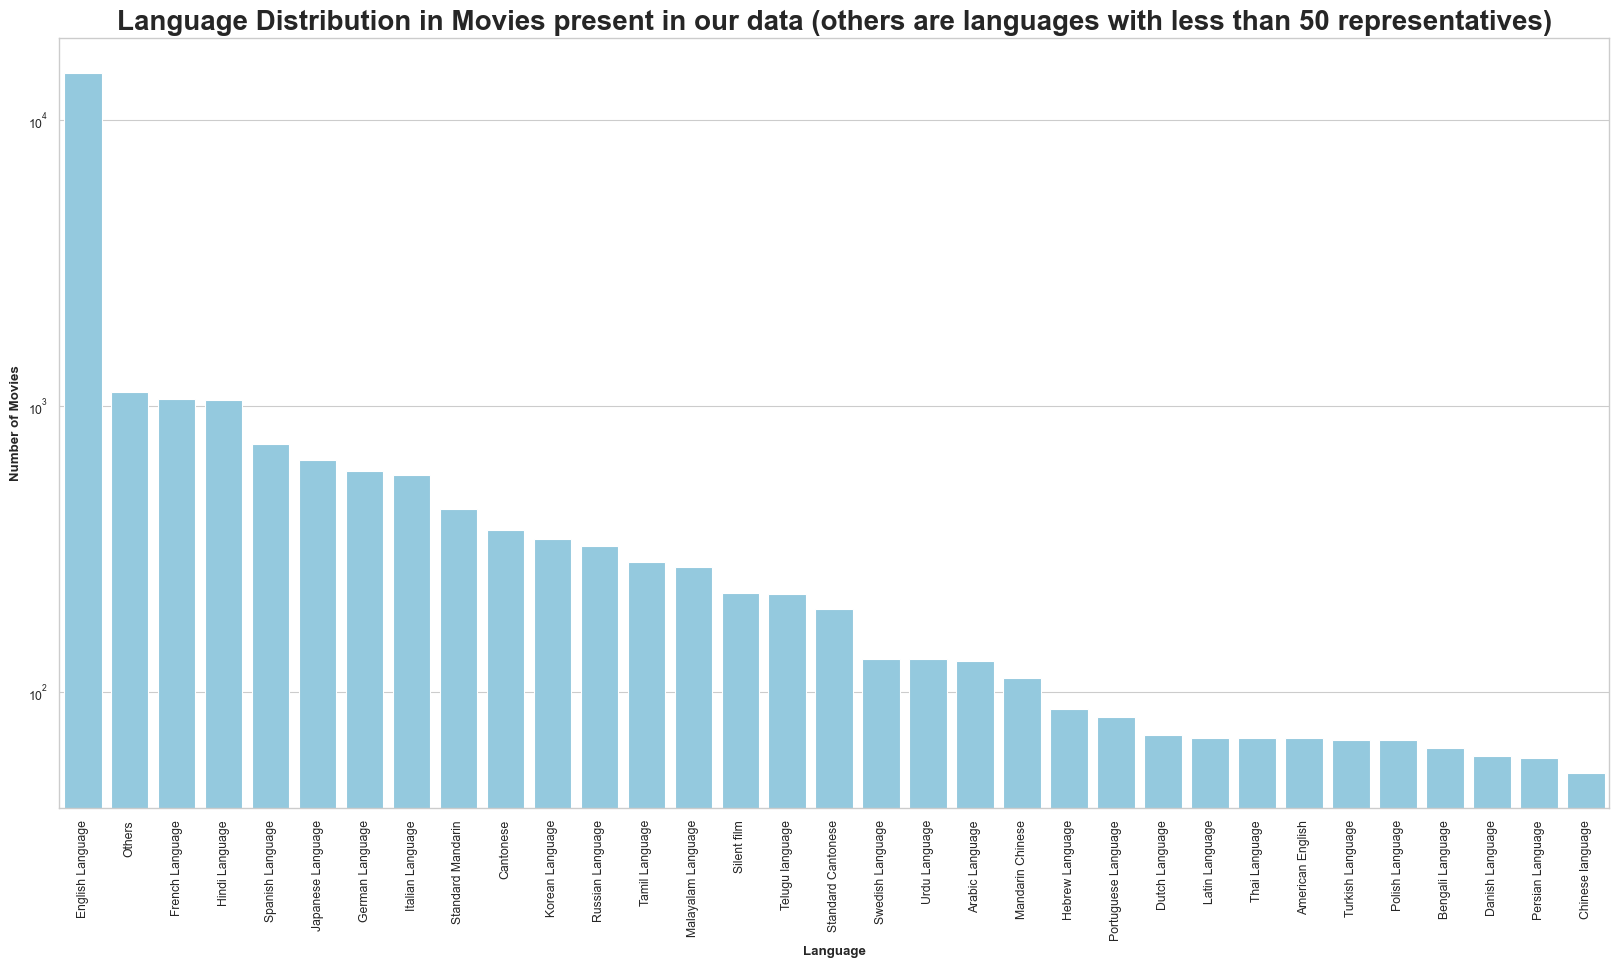

In [32]:
df = languages_ratings_df.copy()
threshold = 50
df.loc[df['language_name'].value_counts()[df['language_name']].values < threshold, 'language_name'] = 'Others'

# plot the histogram with log scale
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.title(f'Language Distribution in Movies present in our data (others are languages with less than {threshold} representatives)')
sns.countplot(data=df, 
              x='language_name',
              order=df['language_name'].value_counts().index,
              color='skyblue',
              log=True)
plt.xlabel('Language')
plt.ylabel('Number of Movies')
plt.show()

Now, having the distribution in mind, lets visualize the reception of films by the public via the plot of rating means recieved. In the following plot you can choose the threshold, filtering out languages that have less representatives and also the number of top languages to show. The confidence interval of 95% is shown on each bar.

In [33]:
from ipywidgets import interact, fixed
from ipywidgets import IntSlider

interact(plot_mean_for_languages,
         languages_ratings_df=fixed(languages_ratings_df), 
         threshold=IntSlider(min=2, max=1000, step=50, value=500), 
         top_n=IntSlider(min=3, max=20, step=1, value=5)
)

interactive(children=(IntSlider(value=500, description='threshold', max=1000, min=2, step=50), IntSlider(value…

<function scripts.helper.plot_mean_for_languages(languages_ratings_df, threshold, top_n=10)>

As we can observe, there are languages that seem to be associated with higher ratings, yet this usually comes together with a larger confidence interval. Thus we can't directly jump  to conclusions. However, if we chose the threshold to be large enough, we see that with a rather small confidence interval, certain languages, such as German and French, outperform the English language. This could be linked to the dataset bias, having sampled better quality films in the inernational cases and lower concerning english markets. If this is the case, it might be a good idea to look into the characteristics of films with languages differning from English to find meaningfull insights. 

In [34]:
interact(plot_data, 
         start=IntSlider(value=2000, min=1900, max=2010, step=10), 
         movies_ratings=fixed(movies_metadata_ratings_df), 
         nb_combinations=IntSlider(min=1, max=3, step=1), 
         nb_genres=IntSlider(value=7,min=1, max=15, step=1), 
         nb_combined_genres=IntSlider(min=1, max=4, step=1))

interactive(children=(IntSlider(value=2000, description='start', max=2010, min=1900, step=10), IntSlider(value…

<function scripts.helper.plot_data(start, movies_ratings, nb_combined_genres=1, nb_genres=10)>

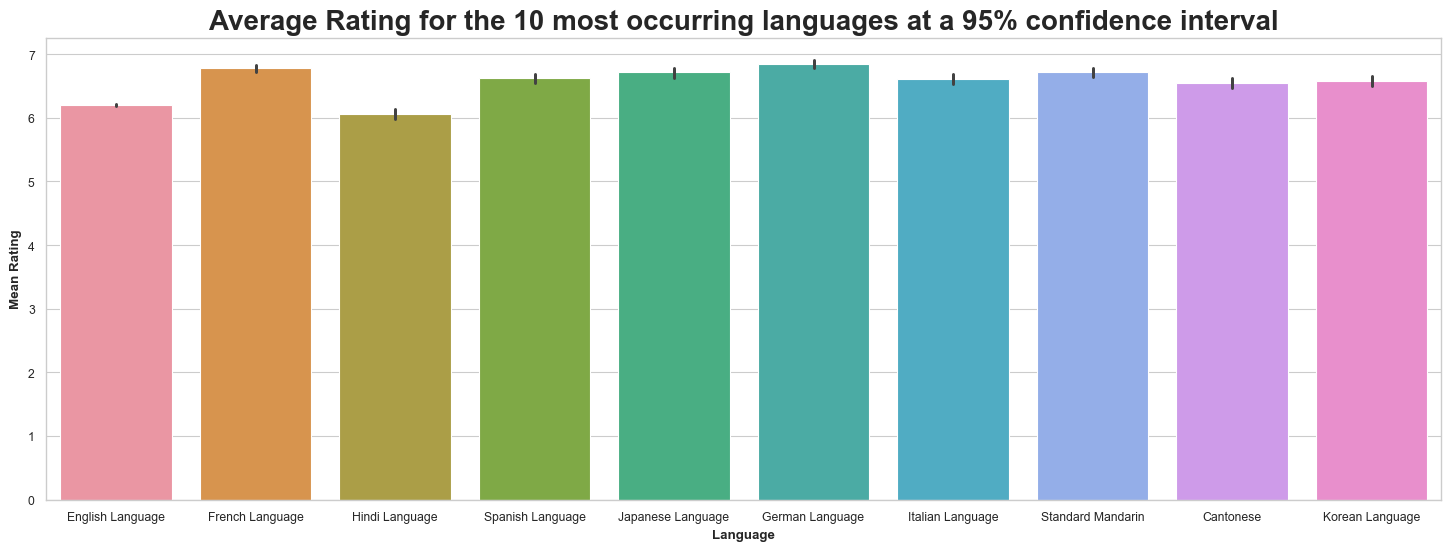

In [35]:
# Group by 'name' and calculate mean and standard deviation
grouped_df = \
    languages_ratings_df.groupby('language_name')['averageRating'].agg(['mean', 
                                                                        'std', 
                                                                        'count'])

# Find the most occurring names
top_names = grouped_df['count'].nlargest(10).index

# Filter the DataFrame for the top names
filtered_df = \
    languages_ratings_df[languages_ratings_df['language_name'].isin(top_names)]

# Group by 'name' again for plotting
plot_data = filtered_df.groupby('language_name')['averageRating']

# Plotting
plt.figure(figsize=(18, 6))
sns.barplot(x='language_name', 
            y='averageRating', 
            data=filtered_df, 
            estimator=np.mean, 
            errorbar=('ci', 95), 
            order=top_names)
plt.xlabel('Language')
plt.ylabel('Mean Rating')
plt.title('Average Rating for the 10 most occurring languages at a 95% confidence interval')
plt.show()

Preforming t-tests showed that if we account leave the english language in the pool of 'other' samples, running a t-test yields a verry small p-value. Removing english shows that some languages tend to get a rather significant p-value, signifying that there may after all be a general tendancy to grade, not specific to each language.

In [36]:
#collecting t-test data on popular languages
languages_to_test =  ['English Language', 
                      'French Language', 
                      'German Language', 
                      'Italian Language', 
                      'Spanish Language', 
                      'Japanese Language', 
                      'German Language', 
                      'Standard Mandarin', 
                      'Korean Language', 
                      'Russian Language', 
                      'Cantonese']

#create an emty map with key language ans value p-value
p_values_with_eng = {}
p_values_without_eng = {}
for language_to_test in languages_to_test:
    p_values_with_eng[language_to_test] = \
        t_test_on_language(language_to_test, languages_ratings_df)[1]
for language_to_test in languages_to_test:
    if language_to_test == 'English Language':
        continue
    p_values_without_eng[language_to_test] = \
        t_test_on_language(language_to_test, languages_ratings_df, elim_English=True)[1]

Performing t-test on differnet languages yields p-values presented in the graph below. For each language we compared the ratings associated to it with the rest of the dataset, having deleted rows with the language being tested.

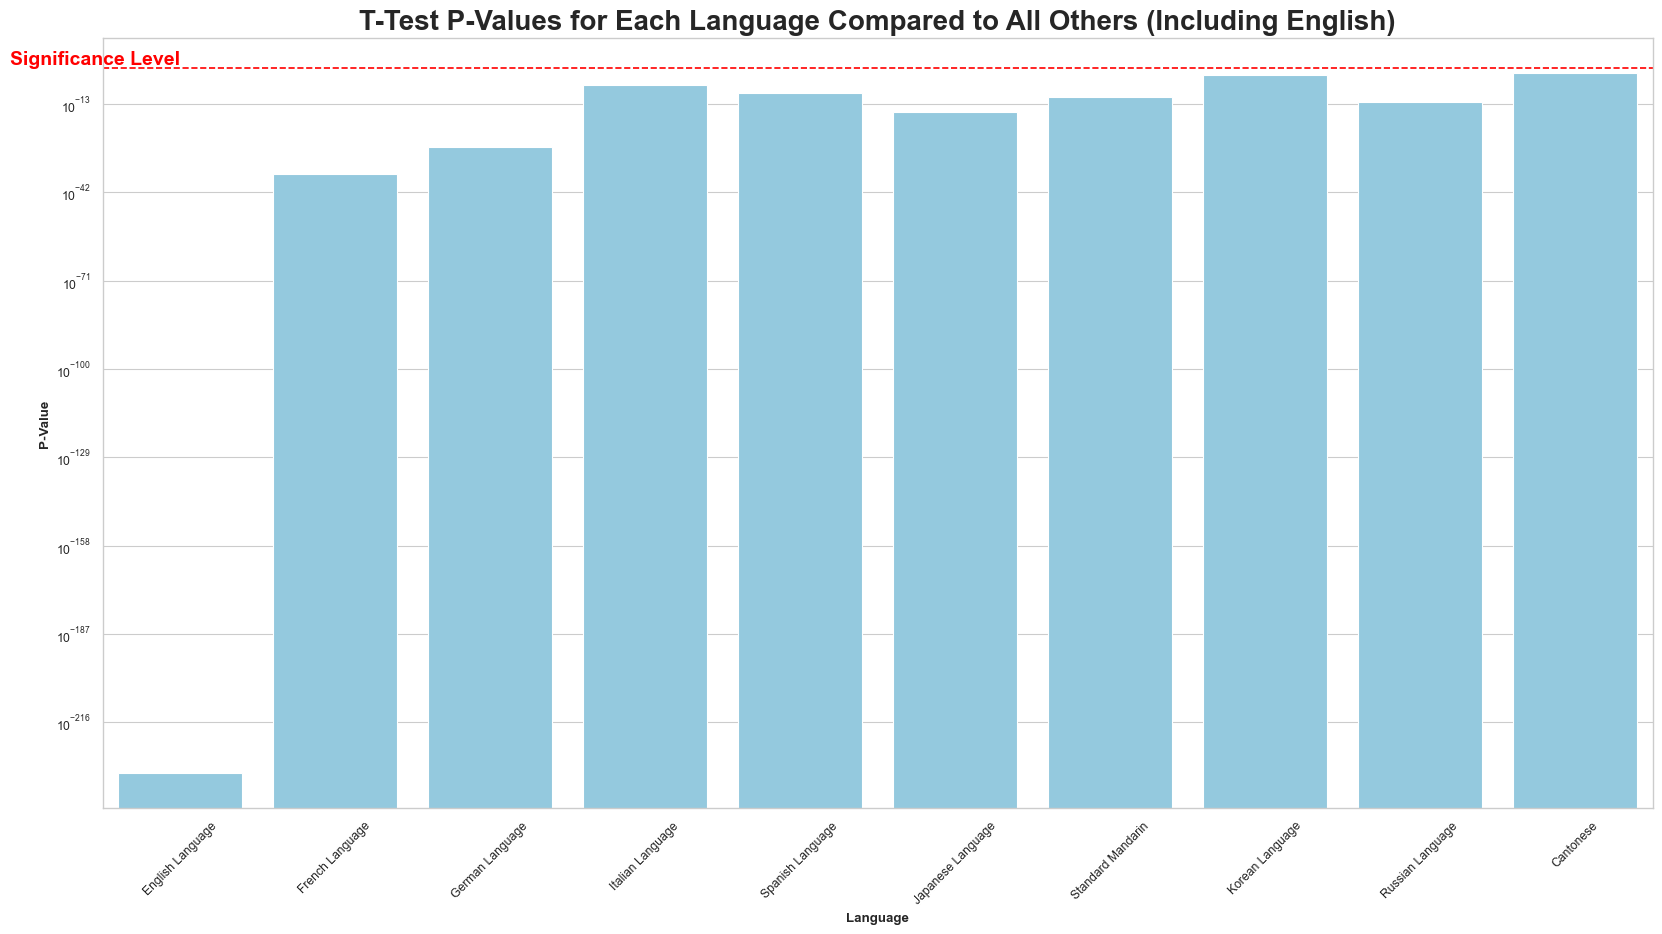

In [37]:
plot_p_values(p_values_with_eng)

As we can see, the p values are very low for all languages, which means that the null hypothesis (that the distribution of the mean rating of the language is the same as the distribution of mean rating of all other languages) is rejected for all languages. This incures that there isn't a geneal law of distributioiin that concerns all languages together. Since the p-value for the english language is orders of magnituds lower, we may suppose that it has a cosiderably different distrigution, however such a feenomena is surely linked to the english language being represented much wider in the dataset, compared to the other languages.

When running an identical procedure but excluding the english language from the data, we get the following plot

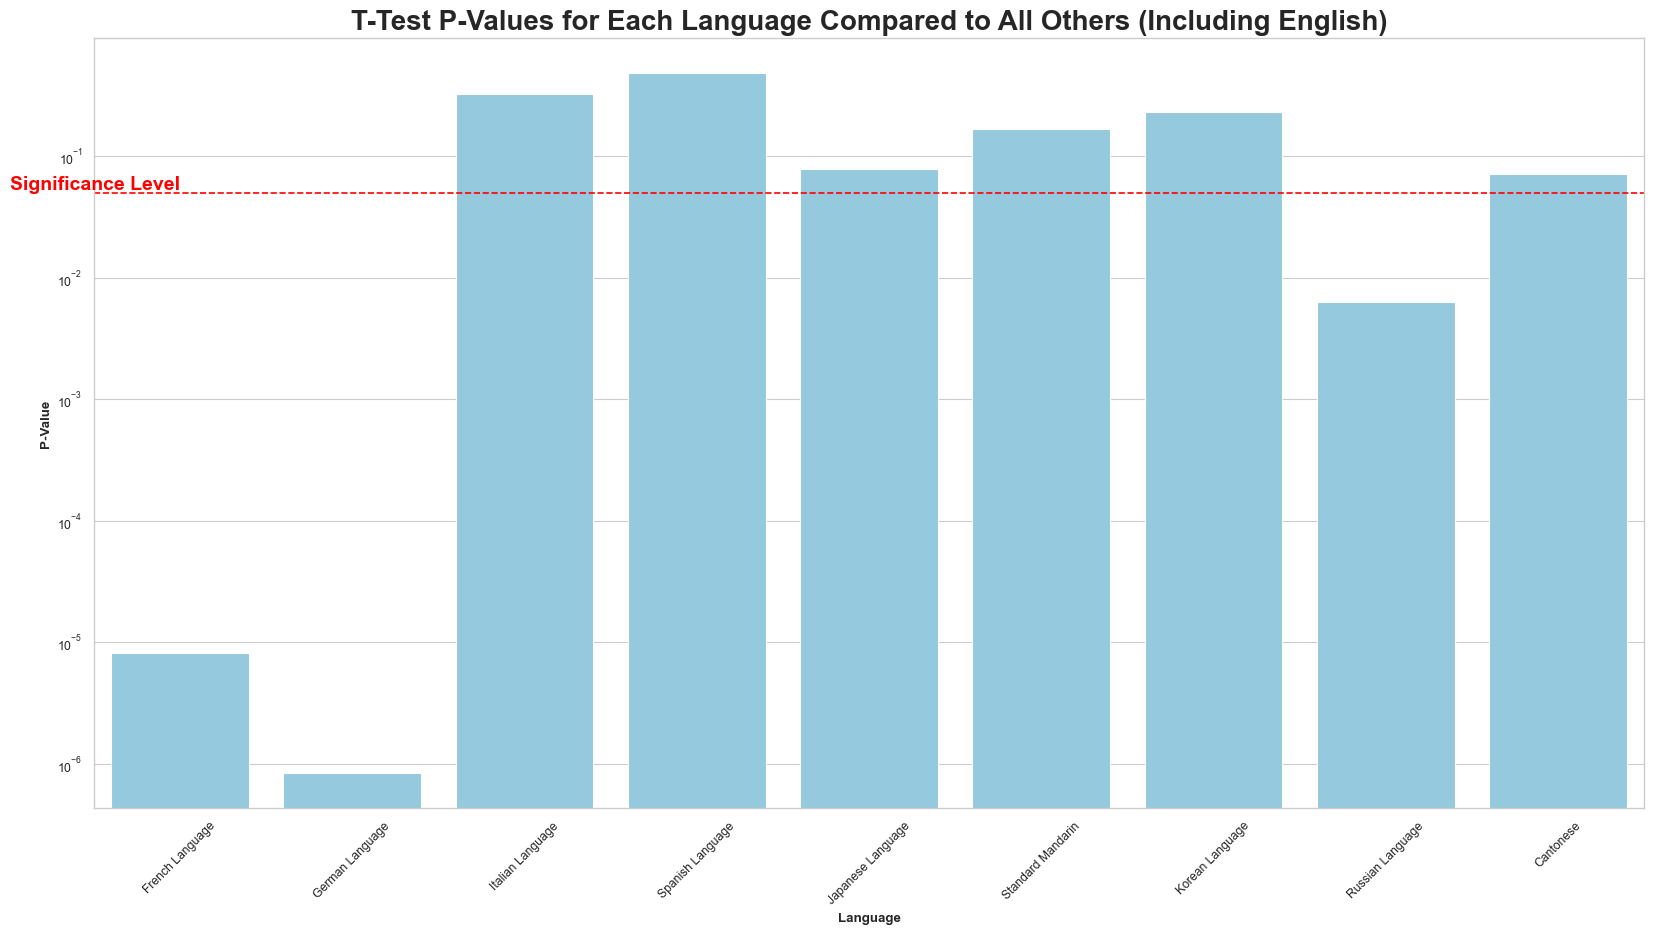

In [38]:
plot_p_values(p_values_without_eng)

Here, we see a less homogenious value, that can be interpreted in a more meaningful insight for finding languages with a distribution differing from the rest of the dataset. However, while some languages tend to have p-value that might support the null hypothesis, those with a larger amount of samples tend to be in the support of the null hypothesis.   

## **2. Keep it Under the Radar!**

Now, one might think that the only way for a movie to get succes on IMDb is to create a huge succes on terms of vues or make it **contreversial** so that it gets more intrest from reviewers. let's analyse this ...

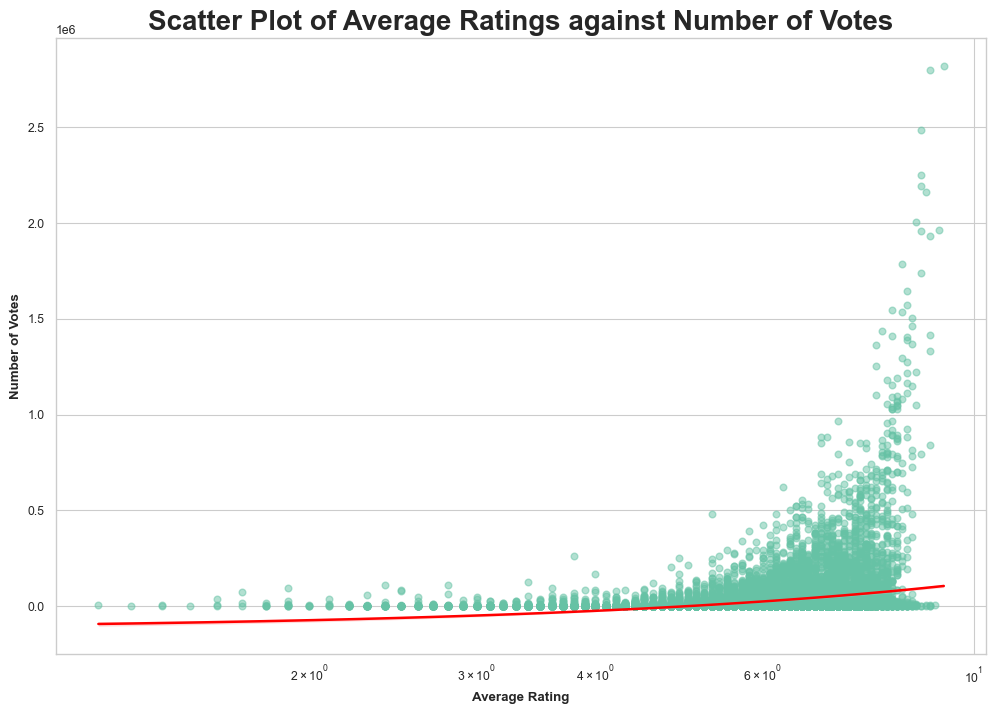

In [39]:
selected_columns = ['numVotes', 'averageRating']
votes_rating_data = movies_metadata_ratings_df[selected_columns]
# Drop rows with missing values (if any)
votes_rating_data = votes_rating_data.dropna()

# Create a scatter plot
plt.figure(figsize=(12, 8))
sns.regplot(x='averageRating', 
            y='numVotes', 
            data=votes_rating_data, 
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red'})

plt.title('Scatter Plot of Average Ratings against Number of Votes')
plt.xlabel('Average Rating')
plt.ylabel('Number of Votes')
plt.xscale('log')
plt.show()

At first we can see here that High Rating doesn't implicate high number of votes. But let's try to fit a regression line into our data. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


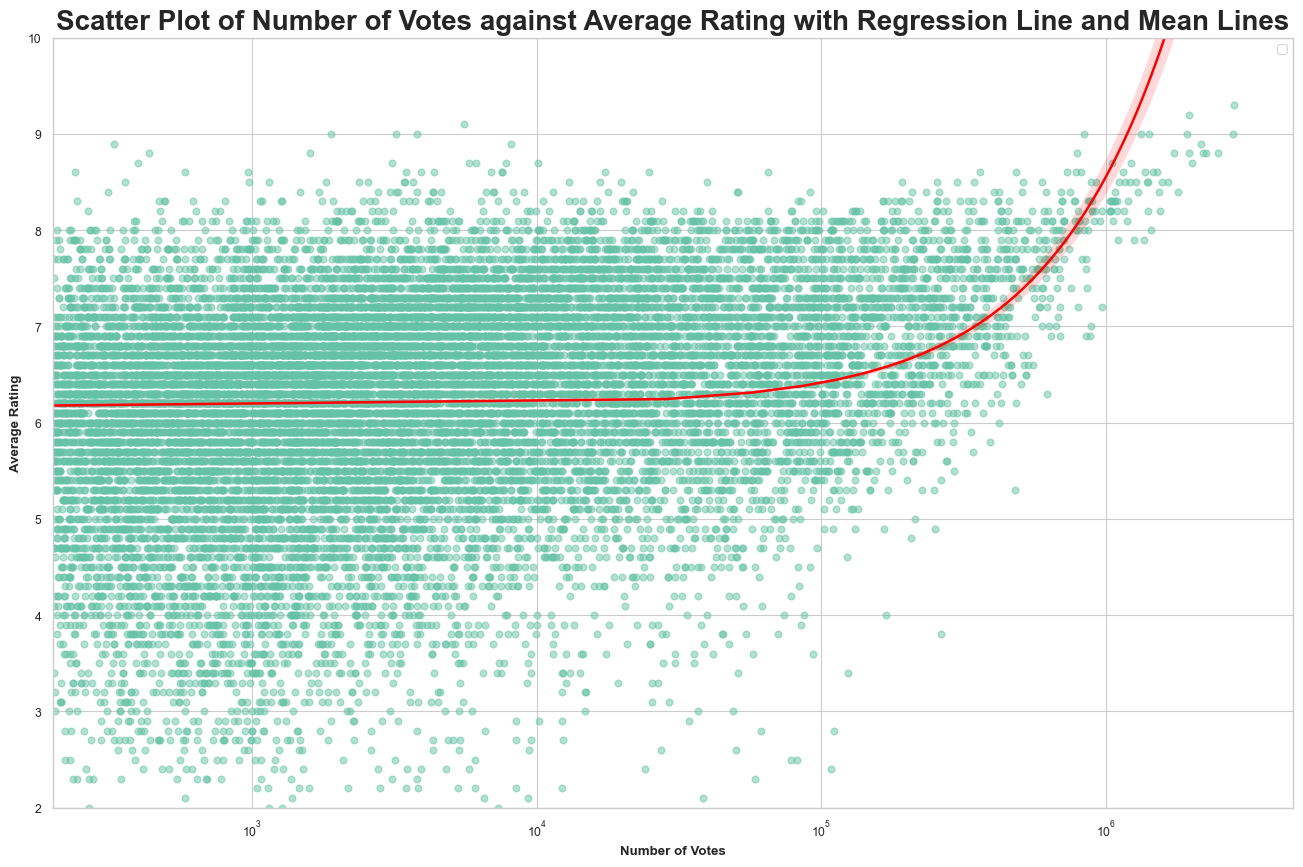

Pearson Correlation Coefficient: 0.24


In [40]:
# Filter relevant columns
selected_columns = ['numVotes', 'averageRating']
votes_rating_data_df = movies_metadata_ratings_df[selected_columns]

# Scatter plot with blue points and red regression line
plt.figure(figsize=(16, 10))
sns.regplot(data=votes_rating_data_df, 
            x='numVotes', 
            y='averageRating', 
            scatter_kws={'alpha': 0.5}, 
            line_kws={'color': 'red'})

# Calculate moving average for each vote number
window_size = 100  # You can adjust the window size according to your preference
moving_avg_by_vote_number = \
    votes_rating_data_df.groupby('numVotes')['averageRating'].rolling(window=window_size).mean().reset_index(level=0, 
                                                                                                             drop=True)

plt.title('Scatter Plot of Number of Votes against Average Rating with Regression Line and Mean Lines')
plt.xlabel('Number of Votes')
plt.xscale('log')
plt.xlim(200)
plt.ylim(2, 10)
plt.ylabel('Average Rating')
plt.legend()  # Show the legend for mean lines
plt.show()

# Calculate Pearson correlation coefficient
correlation_coefficient = \
    votes_rating_data_df['numVotes'].corr(votes_rating_data_df['averageRating'], 
                                          method='pearson')
print(f"Pearson Correlation Coefficient: {correlation_coefficient:.2f}")


Based on the Pearson Correlation Coefficient of 0.24, we can see that the strength of the linear relationship is weak. This means that while there is a positive trend. the number of votes doesn't influence the average rating. We might need a deeper analysis on the type of distribution we are dealing with. Here the idea is to divide the data inty 5 bins based on the number of votes and see how the rating is distributed in each bin.

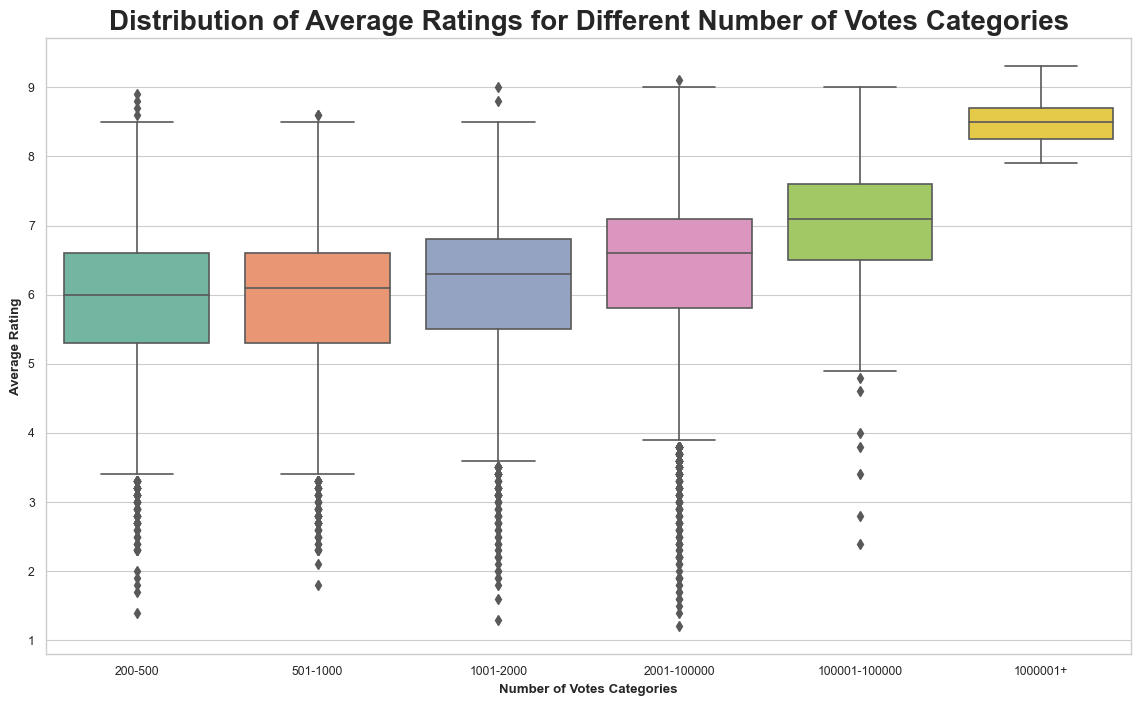

In [41]:
# Filter relevant columns
selected_columns = ['numVotes', 'averageRating']
votes_rating_data_df = movies_metadata_ratings_df[selected_columns]

# Drop rows with missing values (if any)
votes_rating_data_df = votes_rating_data_df.dropna()

# Create a new column for vote number categories (you can adjust the bin edges)
bins = [200, 500, 1000, 2000, 100000, 1000000, float('inf')]
label = ['200-500', '501-1000', '1001-2000', '2001-100000', '100001-100000', '1000001+']
votes_rating_data_df['numVotesCategory'] = \
    pd.cut(votes_rating_data_df['numVotes'], bins=bins, labels=label)

# Create a box plot to compare the distribution of ratings for different vote number categories
plt.figure(figsize=(14, 8))
sns.boxplot(x='numVotesCategory', 
            y='averageRating', 
            data=votes_rating_data_df, 
            order=label)
plt.title('Distribution of Average Ratings for Different Number of Votes Categories')
plt.xlabel('Number of Votes Categories')
plt.ylabel('Average Rating')
plt.show()

Now we can have a clearer conclusion which is that starting at a certain thershold of number of votes the rating will always be high. 

But this also means that under that threshold the number of votes won't affect that much your rating, hence, keeping your movie under the radar might be the best way to increase your rating.

## **3. Movie Era can be a Factor**

In [42]:
# Calculate yearly stats across movies 
stats_by_year_df = \
    movies_metadata_ratings_df.groupby(movies_metadata_ratings_df['movie_release_year']).apply(lambda x: pd.Series({
        'average_worldwide_rating': x['averageRating'].mean(),
        'std_dev_worldwide_rating': x['averageRating'].std()
        }))

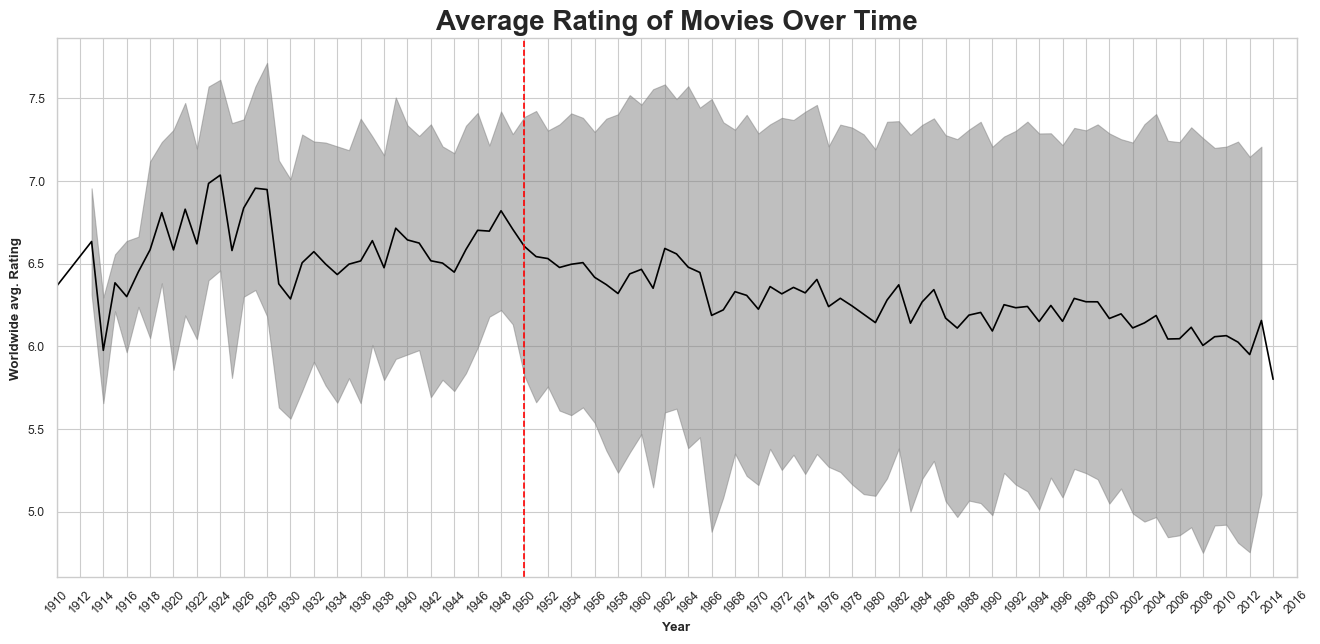

In [43]:
plt.figure(figsize=(16, 7))
plt.fill_between(stats_by_year_df.index, 
                 stats_by_year_df.average_worldwide_rating - stats_by_year_df.std_dev_worldwide_rating,
                 stats_by_year_df.average_worldwide_rating + stats_by_year_df.std_dev_worldwide_rating, 
                 alpha = 0.5, 
                 color = 'gray')

plt.plot(stats_by_year_df.average_worldwide_rating, color = 'black')
plt.axvline(x=1950, color='red', linestyle='--', label='Transition to colored movies')

plt.xlabel('Year')
plt.xlim(1910, 2016)
plt.xticks(range(1910, 2016 + 1, 2))
plt.xticks(rotation=45)
plt.ylabel('Worldwide avg. Rating')
plt.title('Average Rating of Movies Over Time')
plt.show()

From this plot, we can conclude that ratings are in a decreasing trend, so if your movie wasn't released in the early 90's it is unlikely that you can hack the system.
Another intresting insight from this plot is that this trend began on 1950s, the years that marked a more widespread adoption of color in the film industry. 
You might need to use black and white visuals in your production to take advantage of this fact.

In [44]:
movies_metadata_ratings_years_df = \
    movies_metadata_ratings_df[['movie_release_year','averageRating']]

movie_before_1950_df = \
    movies_metadata_ratings_years_df[movies_metadata_ratings_years_df['movie_release_year'] < 1950]['averageRating']
movie_after_1950_df = \
    movies_metadata_ratings_years_df[movies_metadata_ratings_years_df['movie_release_year'] >= 1950]['averageRating']

movie_before_after_1950_df = \
    pd.DataFrame({'before_1950': movie_before_1950_df, 
                  'after_1950': movie_after_1950_df})

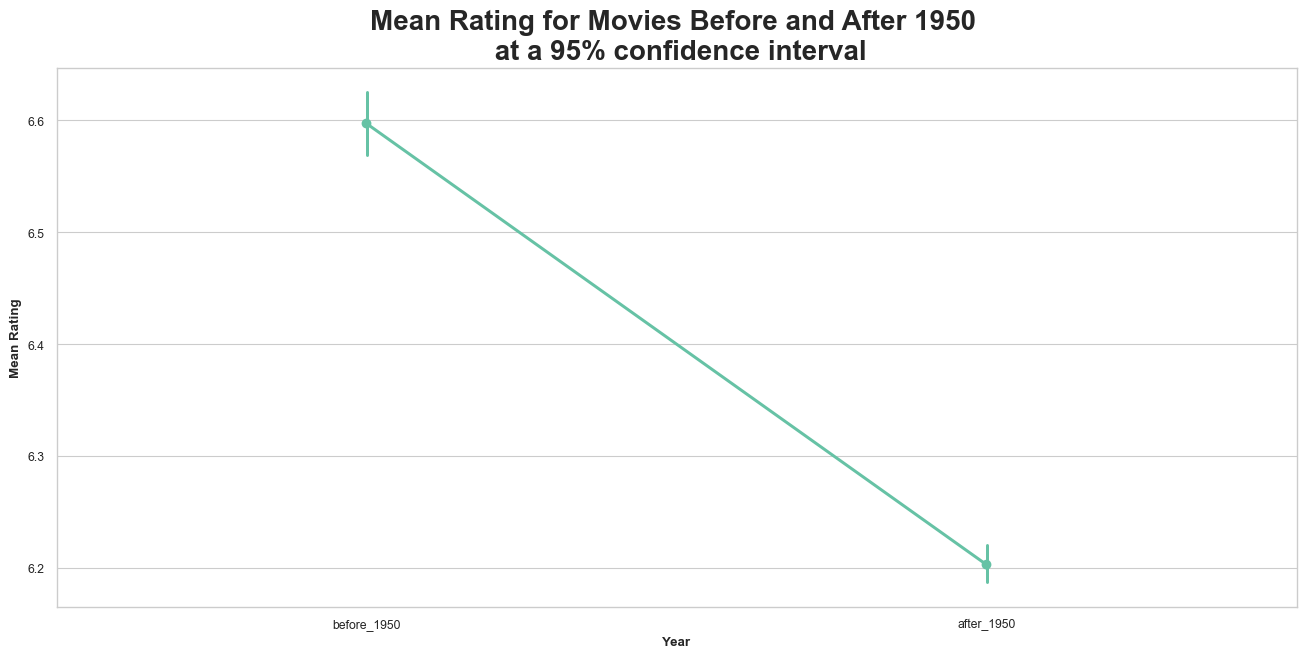

In [45]:
# Plot the mean rating for movies before and after 1950
plt.figure(figsize=(16, 7))
sns.pointplot(data=movie_before_after_1950_df,  
              errorbar=("ci", 95))

plt.title("Mean Rating for Movies Before and After 1950 \n at a 95% confidence interval")
plt.xlabel("Year")
plt.ylabel("Mean Rating")
plt.grid(axis='y', linestyle='-')
plt.show()

In [46]:
_,p_value = stats.ttest_ind(movie_before_1950_df, movie_after_1950_df)
print(f"p-value for t-test on films before 1950 and after: {p_value}")

p-value for t-test on films before 1950 and after: 1.5772968896393338e-65


- The p-value is of magnitude -65, which is less than 0.05. We can reject the null hypothesis that the distribution of ratings is the same for movies released before and after 1950.

Now, we can conclude that the year of release is a factor that can affect the rating of a movie. Or at least the way it was filmed can affect the rating and that people tend to prefer older movies.

## **4. Movie Runtime and Average Rating**

We define the `movie_runtime_rating_df` dataframe, which contains the runtime and the averageRating of each movie

In [47]:
movie_runtime_rating_df = \
    movies_metadata_ratings_df[['movie_runtime','averageRating']]
filtered_movie_runtime_rating_df = \
    movie_runtime_rating_df[movie_runtime_rating_df['movie_runtime'] < 400]
movie_runtime_rating_df.head()

,movie_runtime,averageRating
0,98.0,4.9
3,106.0,5.9
8,137.0,7.5
9,139.0,7.8
13,82.0,6.1


Now we create a jointplot to visualise the relationship between the movie runtime and the avetage rating along with their individual distributions

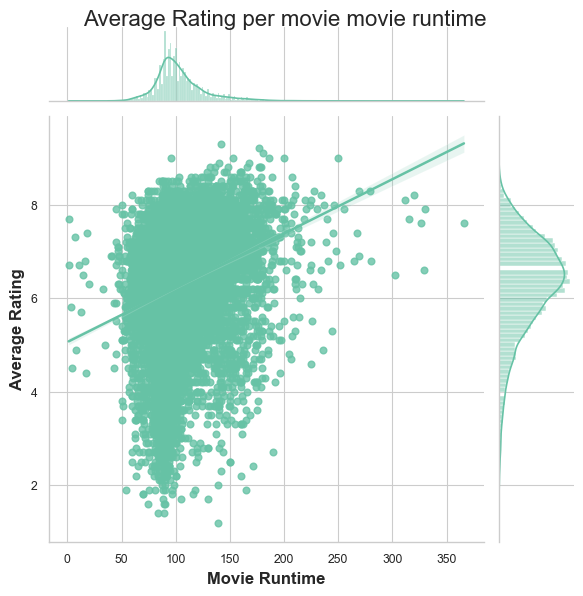

In [48]:
g = sns.jointplot(x=filtered_movie_runtime_rating_df['movie_runtime'], 
                  y=filtered_movie_runtime_rating_df['averageRating'], 
                  kind='reg', 
                  height=6)

# Set labels and title
g.set_axis_labels('Movie Runtime', 'Average Rating', fontsize=12)
g.fig.suptitle('Average Rating per movie movie runtime ', fontsize=16)
g.fig.subplots_adjust(top=0.95)

In [49]:
#performing an ols on the movie runtime of each movie
reg = smf.ols('averageRating ~ movie_runtime', 
              data=filtered_movie_runtime_rating_df).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     1356.
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          7.92e-287
Time:                        22:50:48   Log-Likelihood:                -27827.
No. Observations:               19224   AIC:                         5.566e+04
Df Residuals:                   19222   BIC:                         5.567e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.0605      0.033    151.072

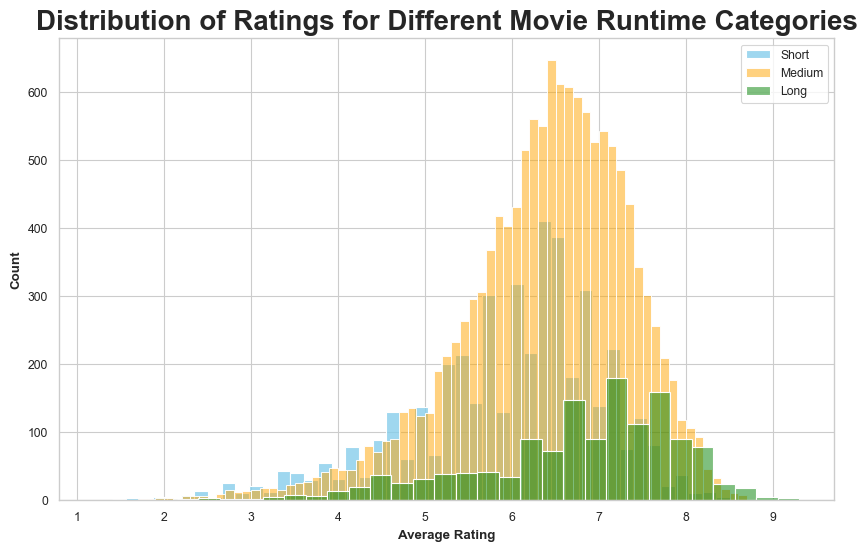

In [50]:
short_df = filtered_movie_runtime_rating_df[filtered_movie_runtime_rating_df['movie_runtime'] < 90]
medium_df = filtered_movie_runtime_rating_df[(filtered_movie_runtime_rating_df['movie_runtime'] >= 90) & 
                                             (filtered_movie_runtime_rating_df['movie_runtime'] <= 140)]
long_df = filtered_movie_runtime_rating_df[filtered_movie_runtime_rating_df['movie_runtime'] > 140]

# Plot the distribution of ratings for each category using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(short_df['averageRating'], label='Short', kde=False, color='skyblue', alpha=0.8)
sns.histplot(medium_df['averageRating'], label='Medium', kde=False, color='orange', alpha=0.5)
sns.histplot(long_df['averageRating'], label='Long', kde=False, color='green', alpha=0.5)

# Set plot labels and title
plt.title('Distribution of Ratings for Different Movie Runtime Categories')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.legend()
plt.show()

### **Interpretation**

The R-squared value of 0.066 and a significant F-statistic p-value suggest that there is a statistically significant relationship between movie runtime and average rating. But movie runtime explains only a small portion of the variability in ratings. Specifically, the 0.0116 coefficient indicates a slight positive relationship: as movie runtime increases, the average rating tends to increase marginally.

Most movies runtimes tend to be in the range 90 to 150 minutes. one might think that the optimal runtime for higher ratings is around 100 to 120 minutes: not too long that it risks losing the audience's attention and not too short to be sufficient enough to develop the plot and characters.

But our analysis indicates that the best bet is a long movie

## **5. Large Revenue Corelation With The IMDB Ratings**

One might think that the IMDb rating is strictly correlated to the revenue. We investigate this hypothesis by plotting a jointplot to highlight the distribution of the average rating in relation with the movie revenue.

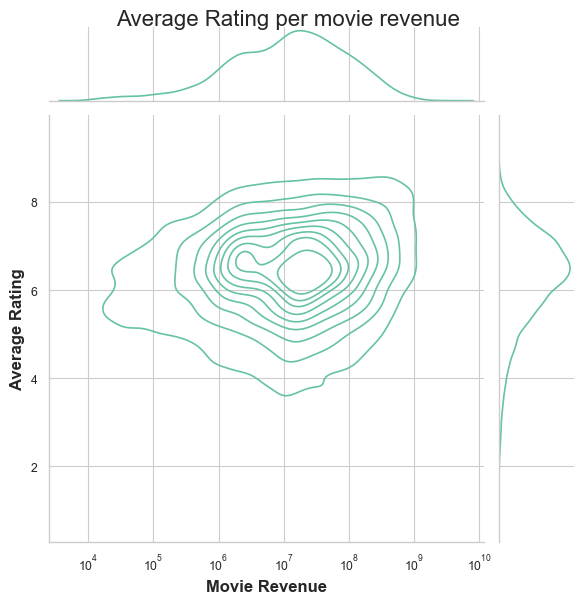

In [51]:
# plot the average rating per movie revenue
g = sns.jointplot(x=movies_metadata_ratings_df['movie_box_office_revenue'],
              y=movies_metadata_ratings_df['averageRating'],
              kind='kde',
              height=6,
              log_scale=(True, False))

# Set labels and title
g.set_axis_labels('Movie Revenue', 'Average Rating', fontsize=12)
g.fig.suptitle('Average Rating per movie revenue', fontsize=16)
g.fig.subplots_adjust(top=0.95)

In [52]:
#perform an ols on the movie revenue of each movie
reg = smf.ols('averageRating ~ movie_box_office_revenue', 
              data=movies_metadata_ratings_df).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     198.8
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           1.71e-44
Time:                        22:50:56   Log-Likelihood:                -9032.0
No. Observations:                6601   AIC:                         1.807e+04
Df Residuals:                    6599   BIC:                         1.808e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### **Interpretation**

One might think that movies with a high box office revenue are for sure movies that people tend to like more but the reality is deceiving.

We can see from the plot above and from the regression that the coefficient is nearly 0 wich means that there is no correlation between the box office revenue and the IMDb rating which is surprizing. This indicates the power of marketing in the movie industry.

## **6. Countries Effect on Movie Ratings** 

Now, we want to see if there's a connection between how people rate movies on IMDb and where those movies come from.

We define the `movie_country_rating_df` dataframe, which contains the countries of movies and the IMDb ratings. We construct this dataframe by reading the `movie_countries` column from the `movie_metadata_ratings_df` dataframe. This column contains a dictionary of country_id and country_name. We then extract the country_name and add it to the a new column called `country_name`.

In [53]:
movie_country_rating_df = \
    movies_metadata_ratings_df[['wiki_movie_id', 
                                'movie_name', 
                                'movie_countries', 
                                'averageRating',
                                ]]

movie_country_rating_df['movie_countries'] = \
    movie_country_rating_df['movie_countries'].apply(lambda x: list(json.loads(x).values()))

# Explode the 'movie_countries' column
movie_country_rating_df = movie_country_rating_df.explode('movie_countries')

# Rename the column and select only the required columns
movie_country_rating_df = \
    movie_country_rating_df.rename(columns={'movie_countries': 'country_name'})[['wiki_movie_id',
                                                                                 'movie_name', 
                                                                                 'country_name', 
                                                                                 'averageRating',
                                                                                 ]]

movie_country_rating_df = \
    movie_country_rating_df[movie_country_rating_df['country_name'].notna()]
movie_country_rating_df.reset_index(drop=True, inplace=True)

# Load country_coordinates assuming the file path is correct
country_coordinates = pd.read_csv('data/GENERATED_DATA/country_coordinates.csv')

# Merge with country coordinates
country_coordinates_ratings_df = pd.merge(movie_country_rating_df, 
                                          country_coordinates, 
                                          on='country_name')

# Group by 'country_name', 'latitude', and 'longitude'
country_coordinates_ratings_df = \
    country_coordinates_ratings_df.groupby(['country_name', 'latitude', 'longitude'])

# Aggregate data with both mean ratings and movie count
average_rating_by_country_and_year_df = \
    country_coordinates_ratings_df.agg({'averageRating': 'mean', 
                                        'wiki_movie_id': 'count'}).reset_index()

# Rename the count column to 'movie_count'
average_rating_by_country_and_year_df = \
    average_rating_by_country_and_year_df.rename(columns={'wiki_movie_id': 'movie_count'})

# Print size of the average_rating_by_country_and_year_df
print(f"Size of the avearge_rating_by_country_and_year_df: {average_rating_by_country_and_year_df.shape}")

# Print sample data from average_rating_by_country_and_year_df
average_rating_by_country_and_year_df.sample(5)

# filter the average_rating_by_country_and_year_df to only include countries with more than 10 movies
average_rating_by_country_and_year_df = \
    average_rating_by_country_and_year_df[average_rating_by_country_and_year_df['movie_count'] > 5]

Size of the avearge_rating_by_country_and_year_df: (128, 5)


In [54]:
import folium
from branca.colormap import LinearColormap

# Assuming average_rating_by_country_and_year_df is your final DataFrame after data processing

# Custom color scale - more intense contrast from light yellow to deep red
color_scale = LinearColormap(['red', 'orange', 'yellow', 'lightgreen', 'green'],
                             vmin=average_rating_by_country_and_year_df['averageRating'].min(),
                             vmax=average_rating_by_country_and_year_df['averageRating'].max())

# Initialize the map
map = folium.Map(location=[0, 0], zoom_start=2)

# Add markers for each country
for _, row in average_rating_by_country_and_year_df.iterrows():
    # Calculate the radius based on the average rating (adjustable factor)
    radius = 3 + (row['averageRating'] - average_rating_by_country_and_year_df['averageRating'].min())

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=radius,
        popup="{}: {:.2f}".format(row['country_name'], row['averageRating']),
        color=color_scale(row['averageRating']),
        fill=True,
        fill_opacity=0.7,
        tooltip=f"{row['country_name']}: {row['averageRating']:.2f}"
    ).add_to(map)

# Display the map
map

We can notice from the world map that the avearge rating of the united states is pretty low (6.15) since it is the country that produces the most movies. countries like slovenia,cambodia and sri lanka for example seem to have a higher ratings. this could be explained by two things:

People that rate movies from their countries are biased, meaning that they tend to vote for a higher rating if the movie is from their country
movies from the united states are more wildely distributed so the opinions could vary more.

Movies from the US are more wildely distributed so the opinions could vary more.

## **7. Linking Events to Movies** 

In this section we are going to try to link movie summaries with historical events, to do that we chose to use the BERT-Large model from hugging face.
- First we tokenize the event description, then we compute the embeddings for this description
- Then we tokenize the summary and we compute the embeddings for this summary

In [55]:
events_embeddings_filename = 'data/EMBEDDINGS/events_embeddings.csv'
plot_summaries_embeddings_filename = 'data/EMBEDDINGS/plot_summaries_embeddings.csv'

In [56]:
# we run the embedding is  in another notebook because it takes 20 h to run :)

Create event description embeddings

In [57]:
if not os.path.exists(events_embeddings_filename):
    # Tokenize, encode, and get embeddings
    events_df['Embeddings'] = \
        events_df['Event Description'].apply(lambda x: encode(x).tolist() if pd.notnull(x) else None)
    
    #save the embeddings of events as a csv file
    events_df.to_csv('data/RESULTS/events_embeddings.csv', index=False)

Create movie summary plot emberddings

In [58]:
if not os.path.exists(plot_summaries_embeddings_filename):
    # add a column to the plot_summaries_df with embedding of the summary
    plot_summaries_df['Embeddings'] = \
        plot_summaries_df['plot_summary'].apply(lambda x: encode(x).tolist() if pd.notnull(x) else None)

    #save the embeddings of summaries as a csv file
    plot_summaries_df.to_csv('data/plot_summaries_embeddings.csv', index=False)

Load the event embeddings and summaries embeddings

In [59]:
events_embedded_df = pd.read_csv(events_embeddings_filename)
# Convert string representation back to tensor
events_embedded_df['Embeddings'] = \
    events_embedded_df['Embeddings'].apply(string_to_tensor)

summaries_embedded_df = pd.read_csv(plot_summaries_embeddings_filename)
# Convert string representation back to tensor
summaries_embedded_df['Embeddings'] = \
    summaries_embedded_df['Embeddings'].apply(string_to_tensor)

We create some helper functions

In [60]:
#create a merged dataset with the movie metadata and the summaries(with the embeddings)
merged_movie_df = pd.merge(summaries_embedded_df, 
                           movies_metadata_ratings_df, 
                           on='wiki_movie_id', 
                           how='inner')

Lastly we compare the embedding of the movie summary with all the events embeddings and we pick the event that matches the most.

In [61]:
linked_movies_and_events_filename = 'data/RESULTS/linked_movies_and_events_df.csv'

if not os.path.exists(linked_movies_and_events_filename):
    # Initialize an empty list to store movie data
    linked_movies_events = []

    # Loop through each movie
    for index, movie in merged_movie_df.iterrows():
        # Your existing logic to get movie_embedding, movie_release_year, similarity, and matched_event
        movie_embedding = movie['Embeddings']
        movie_release_year = movie['movie_release_year']
        similarity, matched_event = \
            match_event_from_summary_embeddings(events_embedded_df, movie_embedding, movie_release_year)
        event_description = events_df[events_df['Event Name'] == \
                                      matched_event]['Event Description'].values[0]

        # Create a dictionary for the current movie
        movie_data = {
            'wiki_movie_id': movie['wiki_movie_id'],
            'movie_name': movie['movie_name'],
            'plot_summary': movie['plot_summary'],
            'matched_event': matched_event,
            'event description': event_description,
            'similarity_score': similarity,
            'rating': movie['averageRating']
        }

        # Append the dictionary to the list
        linked_movies_events.append(movie_data)

    # Create a DataFrame from the list of dictionaries
    linked_movies_and_events_df = pd.DataFrame(linked_movies_events)

    #save the dataframe to csv
    linked_movies_and_events_df.to_csv(linked_movies_and_events_filename, index=False)

In [62]:
# the comparison is made in another notebook (takes about 30 minutes to run)

After running the Bert model to get the embeddings and assigning each movie to an event we read the resulting file 
- After inspecting manually the results we chose a thresholf of 0.77 to be the thresholf of considering a movie as related to a real world event.

In [63]:
# read the linked_movies_and_events_df 
linked_movies_and_events_df = pd.read_csv(linked_movies_and_events_filename)

linked_movies_and_events_df.sort_values(by=['similarity_score'], ascending=False, inplace=True)

#save the dataframe to csv
linked_movies_and_events_df.to_csv(linked_movies_and_events_filename, index=False)

movies_related_to_events_df = \
    linked_movies_and_events_df[linked_movies_and_events_df['similarity_score'] > 0.77]

movies_unrelated_to_events_df = \
    linked_movies_and_events_df[linked_movies_and_events_df['similarity_score'] < 0.77]

We calculate the average rating for movies considered related to a real world event and for those consiodered as not related to movie events and perform a t-test.

In [64]:
average_rating_all = linked_movies_and_events_df['rating'].mean()
average_rating_related = movies_related_to_events_df['rating'].mean()
average_rating_unrelated = movies_unrelated_to_events_df['rating'].mean()
print('Average rating of movies related to events:', average_rating_related)
print('Average rating of movies unrelated to events:', average_rating_unrelated)
print('Average rating of movies', average_rating_all)

# perform the t-test
stats.ttest_ind(movies_related_to_events_df['rating'], 
                movies_unrelated_to_events_df['rating'])

print('p-value: ', 
      stats.ttest_ind(movies_related_to_events_df['rating'], 
                      movies_unrelated_to_events_df['rating'])[1])

Average rating of movies related to events: 6.31342229199372
Average rating of movies unrelated to events: 6.247167520194286
Average rating of movies 6.251343062082611
p-value:  0.03441312168912531


We can see that the p-value is less than 0.05 so we can reject the null hyposesis.
- We can interpret that the fact that a movie is related to a historical event improves the IMDb rating.

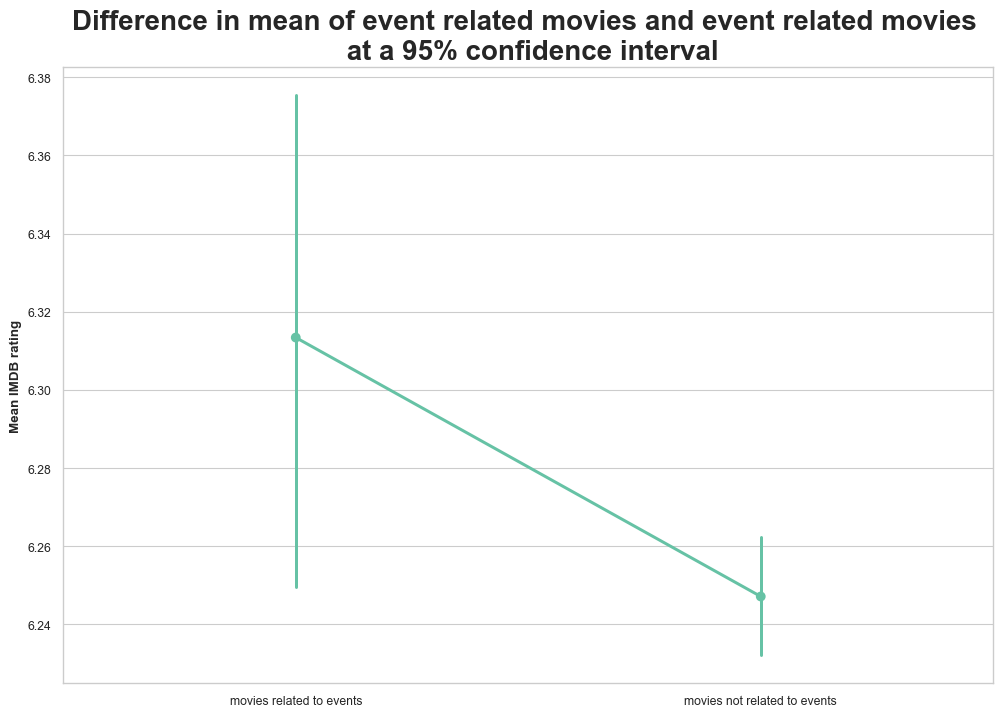

In [65]:
related_unrelated_movies_df = \
    pd.DataFrame({'movies related to events': movies_related_to_events_df['rating'] , 
                  'movies not related to events': movies_unrelated_to_events_df['rating']})

plt.figure(figsize=(12, 8))
# plot the mean salary for each throwing hand
sns.pointplot(data=related_unrelated_movies_df, errorbar=("ci", 95))
plt.title("Difference in mean of event related movies and event related movies \n at a 95% confidence interval")
plt.ylabel("Mean IMDB rating")
plt.grid(axis='y', linestyle='-')
plt.show()

### **Pair Matching**

In [66]:
genres_df = movies_metadata_ratings_df.copy()
genres_df = genres_df.set_index('wiki_movie_id')
genres_df = genres_df['movie_genres']
genres_df = genres_df.apply(lambda x: ast.literal_eval(x))
genres_df = pd.DataFrame(genres_df.tolist(), index=genres_df.index)

for col in genres_df.columns:
    genres_df.rename(columns={col: genres_df[col].dropna().unique()[0]}, inplace=True)

genres_df = genres_df.fillna(0)
genres_df[genres_df != 0] = 1

genres_df.sample(5)

,Thriller,Science Fiction,Horror,Adventure,Supernatural,Action,Space western,Drama,Costume drama,War film,...,Buddy Picture,Journalism,Expressionism,Early Black Cinema,Finance & Investing,New Queer Cinema,The Netherlands in World War II,Goat gland,Revisionist Fairy Tale,Concert film
wiki_movie_id,,,,,,,,,,,,,,,,,,,,,
1353277,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
8656796,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
946305,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24192275,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2347609,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
# make a copy of the dataframe
linked_movies_and_events_df_copy = linked_movies_and_events_df.copy()
# keep only 'wiki_movie_id', 'similarity_score', 'rating' columns
linked_movies_and_events_df_copy = \
    linked_movies_and_events_df_copy[['wiki_movie_id', 'similarity_score', 'rating']]
# set index to 'wiki_movie_id'
linked_movies_and_events_df_copy = \
    linked_movies_and_events_df_copy.set_index('wiki_movie_id')

# add related to events column
linked_movies_and_events_df_copy['related_to_event'] = \
    linked_movies_and_events_df_copy['similarity_score'].apply(lambda x: 1 if x > 0.77 else 0)
#drop similarity_score column
linked_movies_and_events_df_copy = \
    linked_movies_and_events_df_copy.drop(columns=['similarity_score'])
#print the related to events =1 
print('Number of movies related to events: ', 
    linked_movies_and_events_df_copy[linked_movies_and_events_df_copy['related_to_event'] == 1].shape[0])

#convert genres_df rows to vectors
genres_df = genres_df.apply(np.array, axis=1)

#drop the rows that are not in linked_movies_and_events_df_copy
genres_df = genres_df.drop(genres_df.index.difference(linked_movies_and_events_df_copy.index))

# join the two dataframes
linked_movies_and_events_df_copy = \
    linked_movies_and_events_df_copy.join(genres_df.rename('genres'), how='inner')
#drop duplicate wiki_movie_id
linked_movies_and_events_df_copy = \
    linked_movies_and_events_df_copy[~linked_movies_and_events_df_copy.index.duplicated(keep='first')]
#drop rows where genres if of size different than 345
linked_movies_and_events_df_copy = \
    linked_movies_and_events_df_copy[linked_movies_and_events_df_copy['genres'].apply(lambda x: len(x) == 345)]

movie_linked_year = movie_metadata_df[['wiki_movie_id', 'movie_release_year']]
movie_linked_year = movie_linked_year.set_index('wiki_movie_id')

Number of movies related to events:  1274


In [68]:
matched_movies_filename = 'data/RESULTS/matched_movies_by_10years.csv'

if not os.path.exists(matched_movies_filename):

    # define the treatment and control groups
    treatment_df = \
        linked_movies_and_events_df_copy[linked_movies_and_events_df_copy['related_to_event'] == 1]
    control_df = \
        linked_movies_and_events_df_copy[linked_movies_and_events_df_copy['related_to_event'] == 0]

    G = pair_match(treatment_df, movie_linked_year, control_df)
    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)

    #create a dataframe with the matching set
    matching_df = pd.DataFrame(matching).T
    # Create a DataFrame from the matching
    matching_df = pd.DataFrame(matching) 
    matching_df.columns = ['movie_id_treatment', 'movie_id_control']

    #add year of release to the dataframe
    matching_df = matching_df.join(movie_linked_year, on='movie_id_treatment')
    #change movie_release_year to int
    matching_df['movie_release_year'] = matching_df['movie_release_year'].astype(int)
    #sort by movie_release_year
    matching_df = matching_df.sort_values(by=['movie_release_year'])
    #make movie_release_year = ceilling(movie_release_year/10)*10
    matching_df['movie_release_year'] = \
        matching_df['movie_release_year'].apply(lambda x: math.ceil(x/10)*10)

    # Save the matching dataframe to a CSV file
    matching_df.to_csv(matched_movies_filename, index=False)
else:
    matching_df = pd.read_csv(matched_movies_filename)

In [69]:
# create treatment_df containing rating of movies
treatment_df = matching_df[['movie_id_treatment', 'movie_release_year']]
# add the rating of the movies
treatment_df = treatment_df.join(linked_movies_and_events_df_copy[['rating']], on='movie_id_treatment')
# make index the movie_id_treatment
treatment_df = treatment_df.set_index('movie_id_treatment')
# create control_df containing rating of movies
control_df = matching_df[['movie_id_control', 'movie_release_year']]
# add the rating of the movies
control_df = control_df.join(linked_movies_and_events_df_copy[['rating']], on='movie_id_control')
# make index the movie_id_control
control_df = control_df.set_index('movie_id_control')

treatment_df.sample(5)

,movie_release_year,rating
movie_id_treatment,,
17451938,1950,6.6
25090637,1940,5.8
1875611,1960,7.3
12613761,1940,6.8
19868108,1940,6.6


In [70]:
show_graph_pair_matching(treatment_df, control_df)

## **8. Evaluate the Effect of Oscars Nominations and Award on Movie Sucess**

Let's see if the Oscars nominations and wins have an effect on the IMDb rating.

### **Nominated movie impact**

We define the `movie_nominated_df` dataframe, which contains the `wiki_movie_id`, `averageRating`, `nominated` and `movie_box_office` of each movie.

In [71]:
#sample movie_metadata_rating_award_df
movie_nominated_df = \
    movie_metadata_rating_award_df[['wiki_movie_id', 
                                    'averageRating', 
                                    'nominated', 
                                    'movie_box_office_revenue']]

movie_nominated_df.sample(5)

,wiki_movie_id,averageRating,nominated,movie_box_office_revenue
26253,11263505,6.1,False,NaN
37981,444245,6.6,False,NaN
6873,28492996,5.4,False,NaN
20041,704406,4.5,False,19221939.0
32760,24943952,7.0,False,NaN


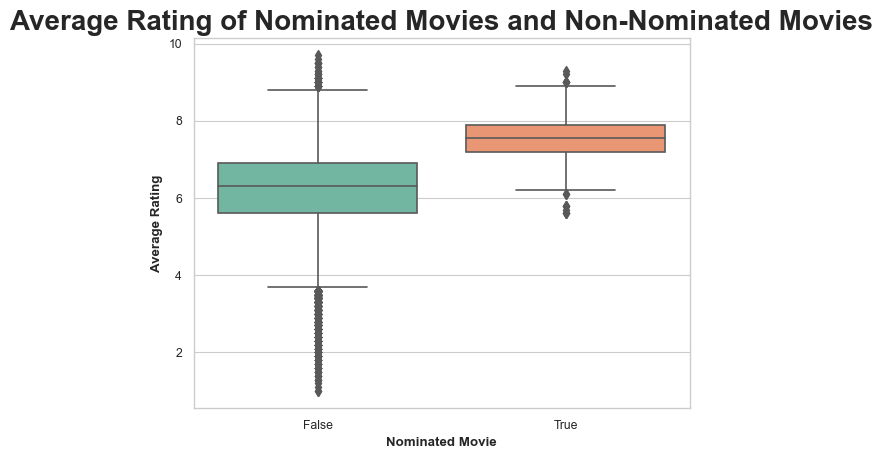

In [72]:
# plot the average rating for nominated and non-nominated movies
sns.boxplot(x='nominated', 
            y='averageRating', 
            data=movie_nominated_df)

plt.xlabel('Nominated Movie')
plt.ylabel('Average Rating')
plt.title('Average Rating of Nominated Movies and Non-Nominated Movies')
plt.show()

In [73]:
#perform an ols on the nominated and non-nominated movies average rating 
reg = smf.ols('averageRating ~ nominated', 
              data=movie_nominated_df).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     665.0
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          1.86e-145
Time:                        22:51:14   Log-Likelihood:                -60163.
No. Observations:               39963   AIC:                         1.203e+05
Df Residuals:                   39961   BIC:                         1.203e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.1877      0.00

### **Winning movie impact**

We define the `movie_winning_df` dataframe, which contains the `wiki_movie_id`, `averageRating`, `winning` and `movie_box_office` of each movie.

In [74]:
#sample movie_metadata_rating_award_df
movie_winner_df = \
    movie_metadata_rating_award_df[['wiki_movie_id', 
                                    'averageRating', 
                                    'winner', 
                                    'movie_box_office_revenue']]

movie_winner_df.sample(5)

,wiki_movie_id,averageRating,winner,movie_box_office_revenue
38376,27289067,6.8,False,NaN
37465,22792066,6.9,False,NaN
8547,2657943,6.3,False,2037545.0
21411,2025985,6.1,False,NaN
29281,15465392,6.5,False,91327197.0


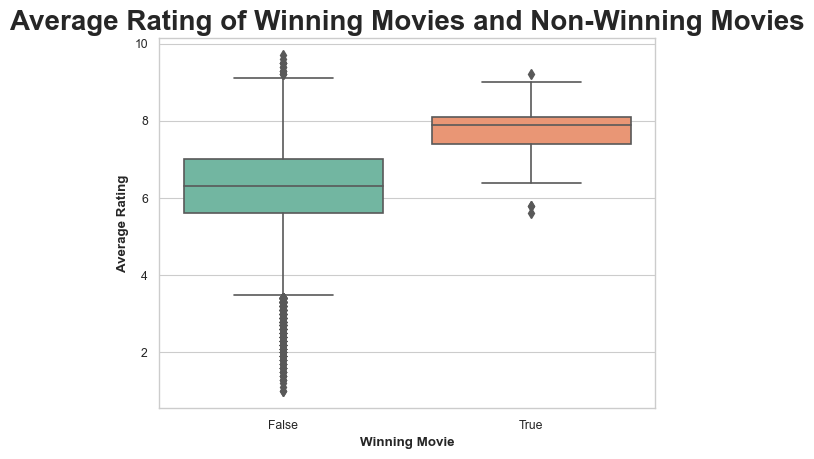

In [75]:
# plot the average rating for winning and non-winning movies
sns.boxplot(x='winner', 
            y='averageRating', 
            data=movie_winner_df)

plt.xlabel('Winning Movie')
plt.ylabel('Average Rating')
plt.title('Average Rating of Winning Movies and Non-Winning Movies')
plt.show()

In [76]:
#perform an ols on the winning and non-winning movies average rating
reg = smf.ols('averageRating ~ winner', 
              data=movie_winner_df).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     157.7
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           4.27e-36
Time:                        22:51:14   Log-Likelihood:                -60415.
No. Observations:               39963   AIC:                         1.208e+05
Df Residuals:                   39961   BIC:                         1.209e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.1997      0.005   1128.

### **Nominated actors impact**

We define the `character_nomination_year_df` dataframe, which contains the actor name and the movie release year.

In [77]:
# keep freebase_character_id, actor_name, movie_release_year columns only
character_nomination_year_df = \
    character_metadata_award_df[['freebase_character_id',
                                 'actor_name', 
                                 'movie_release_year']]

print("Size of the character_award_year_df:", character_nomination_year_df.shape)
character_nomination_year_df.sample(5)

Size of the character_award_year_df: (1452, 3)


,freebase_character_id,actor_name,movie_release_year
1072,/m/02nwj8p,Hilary Swank,2004.0
986,/m/0722b8,Bette Davis,1962.0
306,/m/02nwq14,Rod Steiger,1965.0
1217,/m/0n4kngb,Anthony Quayle,1969.0
979,/m/0bg6nj7,Rachel Weisz,2005.0


We create a subset of the `character_metadata_df` dataframe called `character_subset_df`. This subset contains the following columns: `wiki_movie_id`, `actor_name`, and `movie_release_year`.

In [78]:
# keep wiki_movie_id, actor_name, movie_release_year columns only
character_subset_df = \
    character_metadata_df[['wiki_movie_id', 
                           'freebase_character_id', 
                           'actor_name', 
                           'movie_release_year']]

# drop na in movie_release_year
character_subset_df = \
    character_subset_df[character_subset_df['movie_release_year'].notna()]

print("Size of the character_subset_df:", character_subset_df.shape)
character_subset_df.sample(5)

Size of the character_subset_df: (192540, 4)


,wiki_movie_id,freebase_character_id,actor_name,movie_release_year
433719,215873,/m/0btydh3,Amy Acker,2002.0
224008,1918494,/m/0bvptjy,David Paymer,2000.0
169226,3777574,NaN,Martha Scott,1973.0
439613,12932741,/m/060v1p4,Michael Maloney,2009.0
130136,1267018,/m/0g98j42,Robbie Gee,2001.0


We merge `character_subset_df` and `character_award_year_df` dataframes based on the `freebase_character_id` and `actor_name` columns. 

Next, we try to know if a nominated actor is staring in a movie, does this movie get a higher rating than a movie that doesn't have a nominated actor.

In [79]:
character_subset_nomination_year_df = pd.merge(character_subset_df, 
                                               character_nomination_year_df, 
                                               on=['freebase_character_id', 'actor_name'], 
                                               how='left', 
                                               suffixes=('', '_nominated'))

# remove rows there movie_release_year_nominated is na
character_subset_nomination_year_df = \
    character_subset_nomination_year_df[character_subset_nomination_year_df['movie_release_year_nominated'].notna()]

character_subset_nomination_year_df['nominated'] = \
    character_subset_nomination_year_df['movie_release_year'] > \
        character_subset_nomination_year_df['movie_release_year_nominated']

# remove columns movie_release_year_nominated
character_subset_nomination_year_df.drop(columns=['movie_release_year_nominated'], inplace=True)

print("Size of the character_subset_nomination_year_df:", character_subset_nomination_year_df.shape)
character_subset_nomination_year_df.sample(5)

Size of the character_subset_nomination_year_df: (5883, 5)


,wiki_movie_id,freebase_character_id,actor_name,movie_release_year,nominated
92723,1330432,/m/0h1jfjr,Mira Sorvino,1995.0,False
162535,177735,NaN,Norma Shearer,1929.0,False
97838,113460,/m/02nwkyp,Tom Berenger,1986.0,False
118728,1055198,/m/0cc1pr_,Madeline Kahn,1973.0,False
74738,20396076,NaN,Norma Shearer,1928.0,False


We create a `movie_nominated_actor_df` dataframe, which contains the average rating of each movie and a column that indicates the number of nominated actors in each movie.

The `nominated_actors` column indicates the number of actors that have been nominated.

In [80]:
#count the number of nominations for each movie
character_subset_nomination_year_df['nominated_actors'] = \
    character_subset_nomination_year_df.groupby('wiki_movie_id')['nominated'].transform('sum')

#remove nominated column
character_subset_nomination_year_df.drop(columns=['nominated'], inplace=True)

#merge the character_subset_nomination_year_df with the movie_metadata_rating_df
movie_nominated_actor_df = pd.merge(movie_metadata_rating_df[['wiki_movie_id', 
                                                              'averageRating', 
                                                              'movie_box_office_revenue']],
                                       character_subset_nomination_year_df,
                                       on='wiki_movie_id', 
                                       how='inner')

print("Size of the movie_nominated_actor_df:", movie_nominated_actor_df.shape)
movie_nominated_actor_df.sample(5)

Size of the movie_nominated_actor_df: (5902, 7)


,wiki_movie_id,averageRating,movie_box_office_revenue,freebase_character_id,actor_name,movie_release_year,nominated_actors
5511,98019,6.4,1900000.0,NaN,Brian Aherne,1956.0,3
2066,61505,6.3,NaN,NaN,Gale Sondergaard,1936.0,0
108,9906067,5.0,10058318.0,NaN,Seymour Cassel,1993.0,2
2171,14760548,7.1,NaN,NaN,Jean Simmons,1950.0,0
5699,60157,7.5,NaN,NaN,Paul Muni,1937.0,4


Now we plot the average rating of the movies compared to the number of nominated actors in each movie.

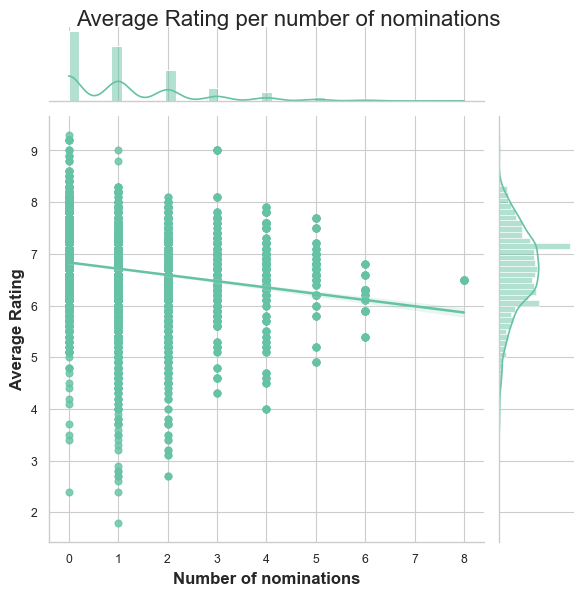

In [81]:
#plot the joint plot of the average rating and the number of nominations
g = sns.jointplot(x=movie_nominated_actor_df['nominated_actors'], 
                  y=movie_nominated_actor_df['averageRating'],
                  kind='reg',
                  height=6)

# Set labels and title
g.set_axis_labels('Number of nominations', 'Average Rating', fontsize=12)
g.fig.suptitle('Average Rating per number of nominations', fontsize=16)
g.fig.subplots_adjust(top=0.95)
plt.show()

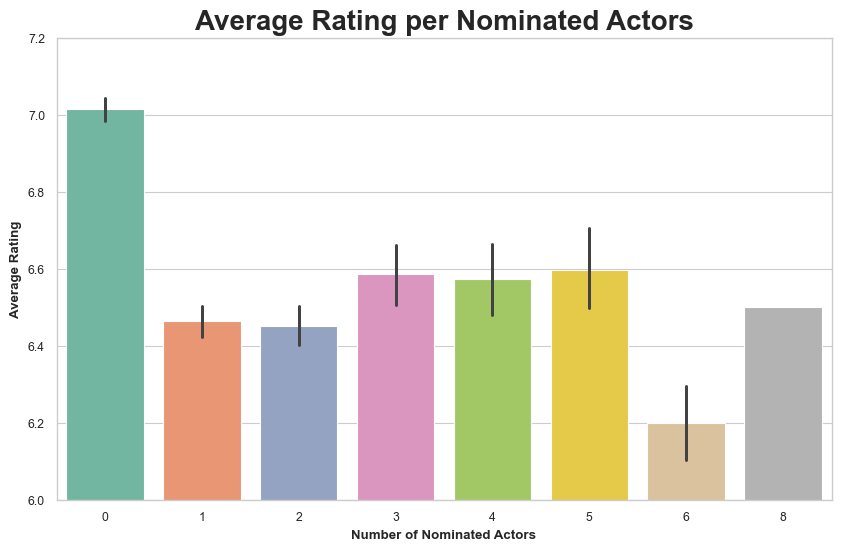

In [82]:
plt.figure(figsize=(10, 6))
sns.barplot(x='nominated_actors', 
            y='averageRating', 
            data=movie_nominated_actor_df, 
            errorbar=('ci', 95))

plt.xlabel('Number of Nominated Actors')
plt.ylabel('Average Rating')
plt.ylim(6, 7.2)
plt.title('Average Rating per Nominated Actors')
plt.show()

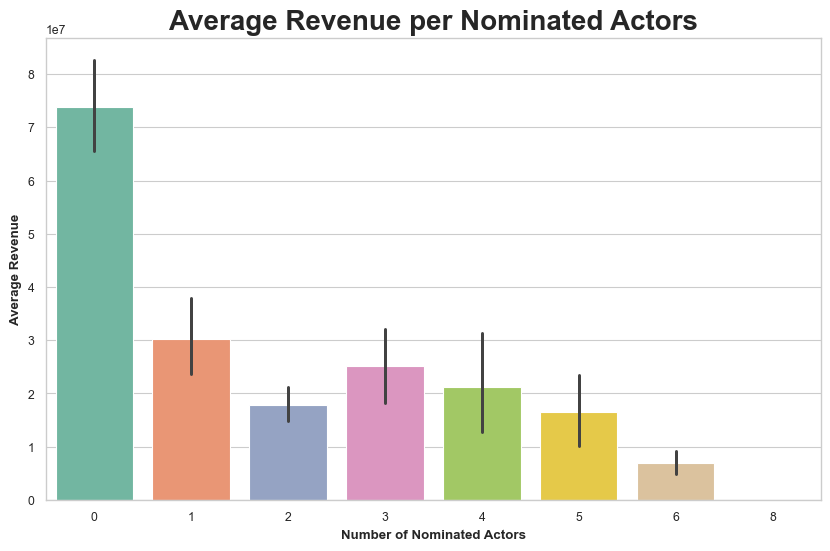

In [83]:
plt.figure(figsize=(10, 6))
sns.barplot(x='nominated_actors', 
            y='movie_box_office_revenue', 
            data=movie_nominated_actor_df, 
            errorbar=('ci', 95))

plt.xlabel('Number of Nominated Actors')
plt.ylabel('Average Revenue')
plt.title('Average Revenue per Nominated Actors')
plt.show()

In [84]:
#perform an ols on the number of nominations of each movie
reg = smf.ols('averageRating ~ nominated_actors', 
              data=movie_nominated_actor_df).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     238.0
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           1.12e-52
Time:                        22:51:20   Log-Likelihood:                -7274.6
No. Observations:                5902   AIC:                         1.455e+04
Df Residuals:                    5900   BIC:                         1.457e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.8337      0.014  

### **Winning actors impact**

We define the `character_metadata_winner_df` dataframe, which contains only the actors that won the oscars.
We also define the `character_winning_year_df` dataframe from the later one, which contains the actor name and the movie release year.

In [85]:
# drop characters that did not win an oscar
character_metadata_winner_df = \
    character_metadata_award_df[character_metadata_award_df['winner'] == True]

# keep freebase_character_id, actor_name, movie_release_year columns only
character_winner_year_df = \
    character_metadata_winner_df[['freebase_character_id', 'actor_name', 'movie_release_year']]

print("Size of the character_winner_year_df:", character_winner_year_df.shape)
character_winner_year_df.sample(5)

Size of the character_winner_year_df: (306, 3)


,freebase_character_id,actor_name,movie_release_year
1449,NaN,Edmund Gwenn,1947.0
967,/m/02nwll0,Audrey Hepburn,1953.0
146,/m/0by5j17,Mary Pickford,1929.0
31,/m/0dsbmr9,Javier Bardem,2007.0
932,/m/0hh0zn1,Martin Landau,1994.0


In [86]:
character_subset_winner_df = pd.merge(character_subset_df, 
                                      character_winner_year_df, 
                                      on=['freebase_character_id', 'actor_name'], 
                                      how='left', 
                                      suffixes=('', '_awarded'))

# remove rows where movie_release_year_awarded is na
character_subset_winner_df = \
    character_subset_winner_df[character_subset_winner_df['movie_release_year_awarded'].notna()]

character_subset_winner_df['won'] = \
    character_subset_winner_df['movie_release_year'] > character_subset_winner_df['movie_release_year_awarded']

# remove columns movie_release_year_awarded
character_subset_winner_df.drop(columns=['movie_release_year_awarded'], inplace=True)

print("Size of the character_subset_winner_df:", character_subset_winner_df.shape)
character_subset_winner_df.sample(5)

Size of the character_subset_winner_df: (1133, 5)


,wiki_movie_id,freebase_character_id,actor_name,movie_release_year,won
56272,1364070,/m/0h2y5qy,Walter Matthau,1966.0,False
576,6512034,NaN,Lionel Barrymore,1941.0,True
120530,7769076,NaN,Maggie Smith,1978.0,True
127595,2559713,NaN,Walter Huston,1932.0,False
175222,7087167,/m/0h2jq50,Grace Kelly,1954.0,False


We define the `movie_winning_actor_df` dataframe, which contains the movie metadata and the Oscars data. We construct this dataframe by merging the `movie_metadata_df` dataframe and the `character_winning_year_df` dataframe.

In [87]:
#count the number of winners for each movie
character_subset_winner_df['winning_actors'] = \
    character_subset_winner_df.groupby('wiki_movie_id')['won'].transform('sum')

#remove won column
character_subset_winner_df.drop(columns=['won'], inplace=True)

#merge the character_subset_winner_year_df with the movie_metadata_rating_df
movie_winning_actor_df = pd.merge(movie_metadata_rating_df[['wiki_movie_id', 
                                                            'averageRating', 
                                                            'movie_box_office_revenue']], 
                                    character_subset_winner_df,
                                    on='wiki_movie_id', 
                                    how='inner')

print("Size of the movie_winning_actor_df:", movie_winning_actor_df.shape)
movie_winning_actor_df.sample(5)

Size of the movie_winning_actor_df: (1136, 7)


,wiki_movie_id,averageRating,movie_box_office_revenue,freebase_character_id,actor_name,movie_release_year,winning_actors
828,4333107,8.2,NaN,NaN,Fay Bainter,1937.0,0
246,2441439,5.0,1547397.0,NaN,Burl Ives,1988.0,1
958,2649257,7.4,1001000.0,NaN,Edmund Gwenn,1940.0,0
811,1645634,5.7,NaN,NaN,John Mills,1978.0,1
714,1141438,7.5,213741459.0,/m/04fmndk,Cate Blanchett,2004.0,0


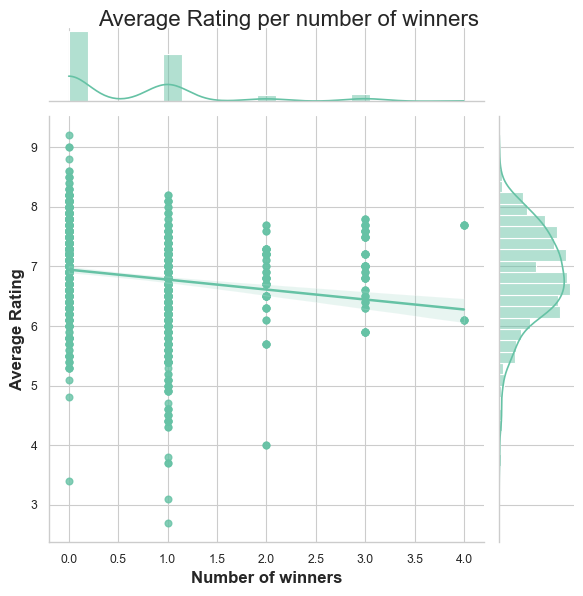

In [88]:
#plot the joint plot of the average rating and the number of winners
g = sns.jointplot(x=movie_winning_actor_df['winning_actors'], 
                  y=movie_winning_actor_df['averageRating'],
                  kind='reg',
                  height=6)

# Set labels and title
g.set_axis_labels('Number of winners', 'Average Rating', fontsize=12)
g.fig.suptitle('Average Rating per number of winners', fontsize=16)
g.fig.subplots_adjust(top=0.95)
plt.show()

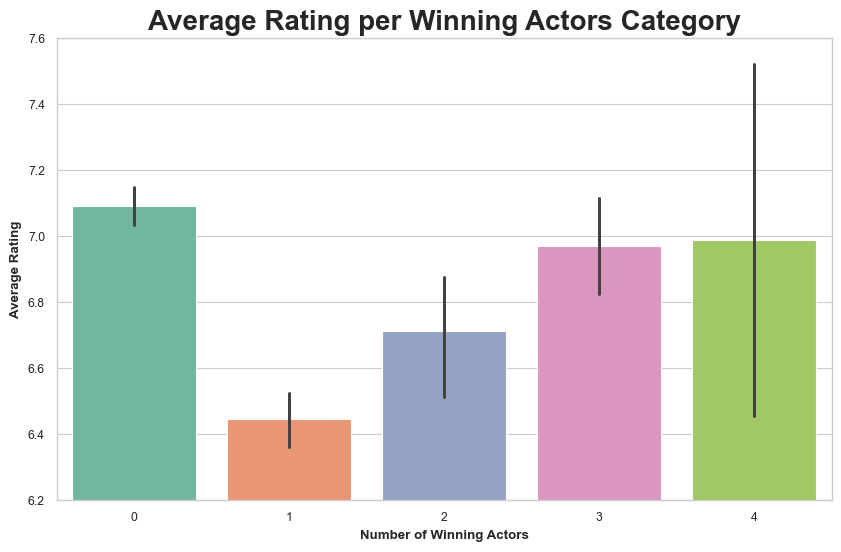

In [89]:
# plot the average rating per winning actors category
plt.figure(figsize=(10, 6))
sns.barplot(x='winning_actors', 
            y='averageRating', 
            data=movie_winning_actor_df, 
            errorbar=('ci', 95))

plt.xlabel('Number of Winning Actors')
plt.ylabel('Average Rating')
plt.ylim(6.2, 7.6)
plt.title('Average Rating per Winning Actors Category')
plt.show()

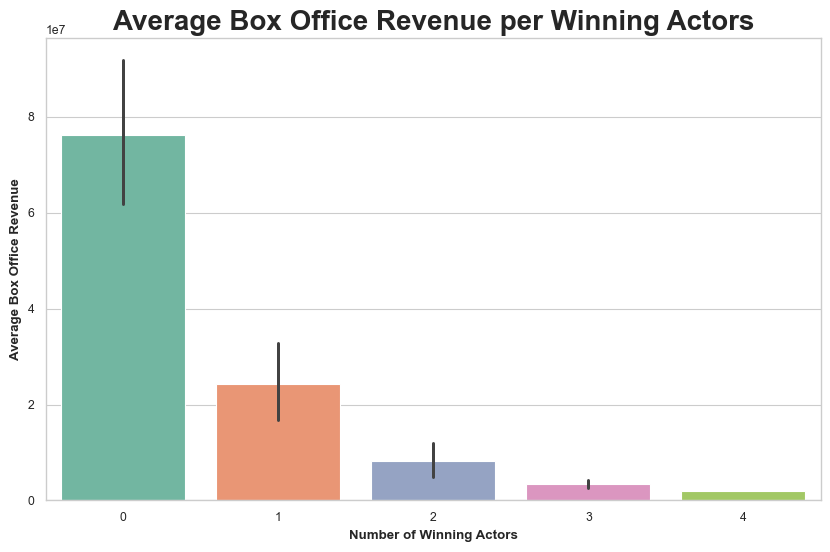

In [90]:
plt.figure(figsize=(10, 6))
sns.barplot(x='winning_actors', 
            y='movie_box_office_revenue', 
            data=movie_winning_actor_df, 
            errorbar=('ci', 95))

plt.xlabel('Number of Winning Actors')
plt.ylabel('Average Box Office Revenue')
plt.title('Average Box Office Revenue per Winning Actors')
plt.show()

In [91]:
#perform an ols on the number of winners of each movie
reg = smf.ols('averageRating ~ winning_actors', 
              data=movie_winning_actor_df).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     36.90
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           1.69e-09
Time:                        22:51:23   Log-Likelihood:                -1358.9
No. Observations:                1136   AIC:                             2722.
Df Residuals:                    1134   BIC:                             2732.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.9451      0.030    233.

## **9. Evaluate the Effect of Ethnicity on the IMDb Rating**

### **Number of actors per movie**

We define the `character_metadata_ethnicity_df` dataframe, which contains the character metadata.

In [92]:
character_metadata_ethnicity_df = character_metadata_df.copy()

number_of_actor_per_movie_df = \
    character_metadata_ethnicity_df.groupby('wiki_movie_id')['actor_name'].apply(lambda x : x.count())
number_of_actor_per_movie_df.name = 'number_of_actor_per_movie'

movie_metadata_rating_ethnicity_df = \
    pd.merge(movie_metadata_rating_df, number_of_actor_per_movie_df, on='wiki_movie_id', how='left')

movie_metadata_rating_ethnicity_df['number_of_actor_per_movie'] = \
    movie_metadata_rating_ethnicity_df['number_of_actor_per_movie'].fillna(0)
movie_metadata_rating_ethnicity_df = \
    movie_metadata_rating_ethnicity_df[movie_metadata_rating_ethnicity_df['number_of_actor_per_movie'] != 0]
movie_metadata_rating_ethnicity_df.sample(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,tconst,averageRating,numVotes,titleType,number_of_actor_per_movie
29587,31733931,/m/0gtvh1c,Heroine,2012-09-21,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama""}",2012.0,tt1949548,5.0,4540,movie,5.0
488,6057698,/m/0fmyf1,A Man Could Get Killed,1966-03-25,NaN,97.0,"{""/m/05zjd"": ""Portuguese Language"", ""/m/02h40l...","{""/m/09c7w0"": ""United States of America""}","{""/m/02kdv5l"": ""Action"", ""/m/01z4y"": ""Comedy"",...",1966.0,tt0060662,5.8,513,movie,5.0
24151,6532516,/m/0g95_y,Race with the Devil,1975,12000000.0,88.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01q03"": ""Cult"", ""/m/0hj3mxr"": ""Chase Movi...",1975.0,tt0073600,6.6,7156,movie,11.0
11241,7639376,/m/0kvd04,Deadly Eyes,1982,NaN,87.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada""}","{""/m/06vxwl5"": ""Natural horror films"", ""/m/03n...",1982.0,tt0083801,4.9,1516,movie,5.0
28110,2162119,/m/06rftn,Merry Andrew,1958,NaN,103.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1958.0,tt0051924,6.6,889,movie,2.0


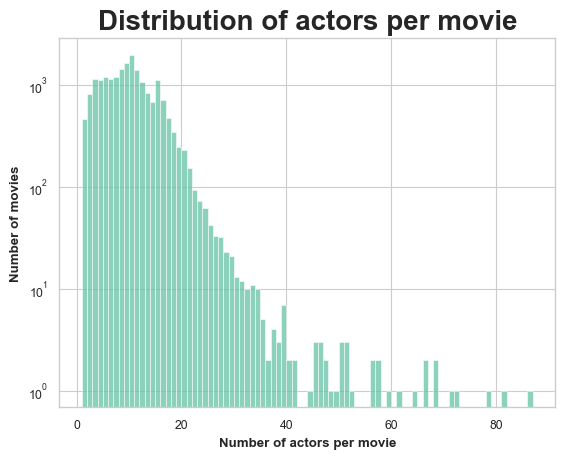

In [93]:
#plot the distribution of actors per movie
sns.histplot(movie_metadata_rating_ethnicity_df["number_of_actor_per_movie"], 
             stat="count", 
             log_scale=(False, True), 
             kde=False, 
             binwidth=1)
plt.xlabel("Number of actors per movie")
plt.ylabel("Number of movies")
plt.title("Distribution of actors per movie")
plt.show()

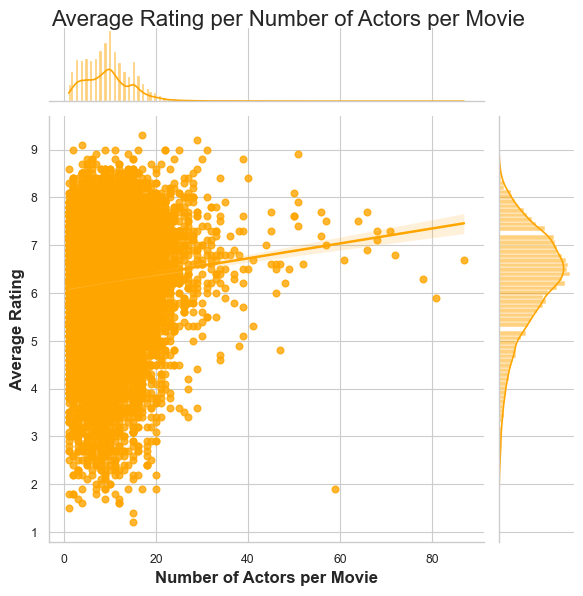

In [94]:
#plot the average rating per number of actors per movie
g = sns.jointplot(x=movie_metadata_rating_ethnicity_df['number_of_actor_per_movie'], 
                  y=movie_metadata_rating_ethnicity_df['averageRating'], 
                  kind='reg', 
                  height=6,
                  ci=95,
                  color='orange')

g.fig.subplots_adjust(top=0.95)
g.set_axis_labels('Number of Actors per Movie', 'Average Rating', fontsize=12)
g.fig.suptitle('Average Rating per Number of Actors per Movie', fontsize=16)
plt.show()

In [95]:
#perform an ols regression for the number of actors per movie
mod = smf.ols(formula='averageRating ~ number_of_actor_per_movie ',
              data=movie_metadata_rating_ethnicity_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     135.3
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           3.62e-31
Time:                        22:51:29   Log-Likelihood:                -29561.
No. Observations:               19841   AIC:                         5.913e+04
Df Residuals:                   19839   BIC:                         5.914e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

coef 0.012 is very small

In [96]:
#perform a spearman correlation test for the number of actors per movie
stats.spearmanr(movie_metadata_rating_ethnicity_df["averageRating"], 
                movie_metadata_rating_ethnicity_df["number_of_actor_per_movie"])

SignificanceResult(statistic=0.07425782699219718, pvalue=1.1419316720399949e-25)

The null hypothesis of a Spearman correlation coefficient test is that there is no monotonic relationship between the two variables here our p < 0.05 this suggest to reject the HO and thus that our weak correlation coefficiant is significant.

à dev

lets dig into that

maybe consider to remove some movie with less than x actor

### **Ethnicity Score**

In [97]:
number_of_ethnicity_per_movie_df = \
    character_metadata_ethnicity_df.groupby('wiki_movie_id')['actor_ethnicity'].apply(lambda x : x.nunique())
number_of_ethnicity_per_movie_df.name = 'number_of_ethnicity_per_movie'

movie_metadata_rating_ethnicity_df = pd.merge(movie_metadata_rating_ethnicity_df, 
                                              number_of_ethnicity_per_movie_df, 
                                              on='wiki_movie_id', 
                                              how='left')

movie_metadata_rating_ethnicity_df = \
    movie_metadata_rating_ethnicity_df[movie_metadata_rating_ethnicity_df['number_of_ethnicity_per_movie'] != 0]

print("Size of movie_metadata_rating_ethnicity_df:", movie_metadata_rating_ethnicity_df.shape)
movie_metadata_rating_ethnicity_df.sample(5)

Size of movie_metadata_rating_ethnicity_df: (14930, 16)


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,tconst,averageRating,numVotes,titleType,number_of_actor_per_movie,number_of_ethnicity_per_movie
8238,8656846,/m/027ct9s,Love and Pain and the Whole Damn Thing,1973-04-19,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/068d7h"": ""Romantic drama"", ""/m/02l7c8"": ""...",1973.0,tt0068850,6.6,920,movie,8.0,1
9169,2837025,/m/085wqm,End of Days,1999-11-24,211989043.0,121.0,"{""/m/02h40lc"": ""English Language"", ""/m/04h9h"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/08w0_f"": ""Albino bias"", ""/m/01jfsb"": ""Thr...",1999.0,tt0146675,5.8,115382,movie,12.0,7
7813,308856,/m/01sxdy,The Phantom of the Opera,2004-12-09,154270000.0,143.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/03npn"": ""Horror"", ""/m/04xvlr"": ""Period pi...",2004.0,tt0293508,7.2,128554,movie,16.0,5
18589,2510385,/m/07jxpf,Jarhead,2005-11-04,96889998.0,125.0,"{""/m/0jzc"": ""Arabic Language"", ""/m/04h9h"": ""La...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0kpq_x"": ""Gulf War"", ""/m/017fp"": ""Biograp...",2005.0,tt0418763,7.0,202083,movie,22.0,6
5632,3813940,/m/0b1bs2,Kiss the Blood Off My Hands,1948-10-30,NaN,79.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1948.0,tt0040512,6.7,1939,movie,3.0,1


In [98]:
movie_metadata_rating_ethnicity_df = \
    movie_metadata_rating_ethnicity_df[movie_metadata_rating_ethnicity_df['number_of_ethnicity_per_movie'] != 0]

print("Size of movie_metadata_rating_ethnicity_df:", movie_metadata_rating_ethnicity_df.shape)

Size of movie_metadata_rating_ethnicity_df: (14930, 16)


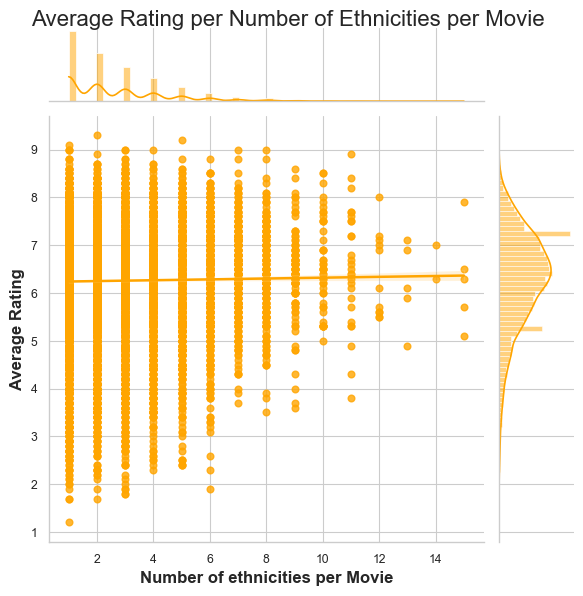

In [99]:
#plot the number of ethnicity per movie
g = sns.jointplot(x=movie_metadata_rating_ethnicity_df['number_of_ethnicity_per_movie'], 
                  y=movie_metadata_rating_ethnicity_df['averageRating'], 
                  kind='reg',
                  height=6,
                  color='orange')

g.fig.subplots_adjust(top=0.95)
g.set_axis_labels('Number of ethnicities per Movie', 'Average Rating', fontsize=12)
g.fig.suptitle('Average Rating per Number of Ethnicities per Movie', fontsize=16)
plt.show()

In [100]:
#perform an ols regression for the number of ethnicity per movie
mod = smf.ols(formula='averageRating ~ number_of_ethnicity_per_movie',
              data=movie_metadata_rating_ethnicity_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.676
Date:                Fri, 22 Dec 2023   Prob (F-statistic):             0.0552
Time:                        22:51:34   Log-Likelihood:                -22083.
No. Observations:               14930   AIC:                         4.417e+04
Df Residuals:                   14928   BIC:                         4.419e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [101]:
#perform a spearman correlation test for the number of ethnicity per movie
stats.spearmanr(movie_metadata_rating_ethnicity_df['averageRating'], 
                movie_metadata_rating_ethnicity_df['number_of_ethnicity_per_movie'])

SignificanceResult(statistic=-0.017991115369107483, pvalue=0.027927800480499816)

We define an **ethnicity score** for each movie based on the **number of actor** in the movie and the **number of ethnicities** in the movie.

In [102]:
#define an ethnicity score for each movie
movie_metadata_rating_ethnicity_df["ethnicity_score"] = \
    movie_metadata_rating_ethnicity_df["number_of_ethnicity_per_movie"] / \
        movie_metadata_rating_ethnicity_df["number_of_actor_per_movie"]

movie_metadata_rating_ethnicity_df.sample(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,tconst,averageRating,numVotes,titleType,number_of_actor_per_movie,number_of_ethnicity_per_movie,ethnicity_score
6709,22826758,/m/06413g2,Confucius,2010-01-28,18600000.0,108.0,"{""/m/0653m"": ""Standard Mandarin""}","{""/m/0d05w3"": ""China""}","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2010.0,tt1397498,6.1,3941,movie,2.0,1,0.500000
19005,24048632,/m/07kbd5d,Buried,2010-01-23,19152480.0,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/02n4kr"": ""Myster...",2010.0,tt1462758,7.0,166590,movie,9.0,2,0.222222
10303,11143116,/m/02r1gkc,Kaakki Sattai,1985-03-14,NaN,NaN,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action""}",1985.0,tt0319622,7.2,308,movie,7.0,4,0.571429
3382,823939,/m/03f418,Twilight,1998-03-06,15055091.0,94.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",1998.0,tt0119594,6.2,13865,movie,11.0,7,0.636364
11567,18766606,/m/04gplm5,The Guilt of Janet Ames,1947-03-06,NaN,83.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...",1947.0,tt0039438,6.3,588,movie,3.0,3,1.000000


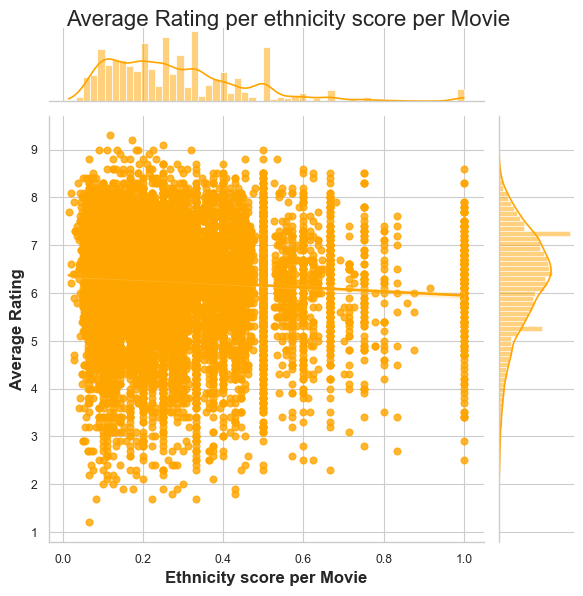

In [103]:
#plot the ethnicity score and the average rating per movie
g = sns.jointplot(x=movie_metadata_rating_ethnicity_df['ethnicity_score'], 
                  y=movie_metadata_rating_ethnicity_df['averageRating'], 
                  kind='reg', 
                  height=6,
                  color='orange')

g.fig.subplots_adjust(top=0.95)
g.set_axis_labels('Ethnicity score per Movie', 'Average Rating', fontsize=12)
g.fig.suptitle('Average Rating per ethnicity score per Movie', fontsize=16)
plt.show()

In [104]:
#perform an ols regression for ethnicity score per movie
mod = smf.ols(formula='averageRating ~ ethnicity_score',
              data=movie_metadata_rating_ethnicity_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     73.26
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           1.25e-17
Time:                        22:51:37   Log-Likelihood:                -22048.
No. Observations:               14930   AIC:                         4.410e+04
Df Residuals:                   14928   BIC:                         4.412e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.3760      0.017    3

In [105]:
#perform a spearman correlation test for the ethnicity score per movie
stats.spearmanr(movie_metadata_rating_ethnicity_df["averageRating"], 
                movie_metadata_rating_ethnicity_df["ethnicity_score"])

SignificanceResult(statistic=-0.09065463172993904, pvalue=1.2703496670958593e-28)

In [106]:
#define two series with the average rating of movies over and under the half score
ethnicity_score_above_half = \
    movie_metadata_rating_ethnicity_df[movie_metadata_rating_ethnicity_df["ethnicity_score"] >= 0.5]["averageRating"]
ethnicity_score_under_half = \
    movie_metadata_rating_ethnicity_df[movie_metadata_rating_ethnicity_df["ethnicity_score"] < 0.5]["averageRating"]

#perform a t-test on the average rating of movies with an ethnicity score over and under the half score
stats.ttest_ind(ethnicity_score_above_half, ethnicity_score_under_half)

TtestResult(statistic=-4.955530953471589, pvalue=7.292341987219383e-07, df=14928.0)

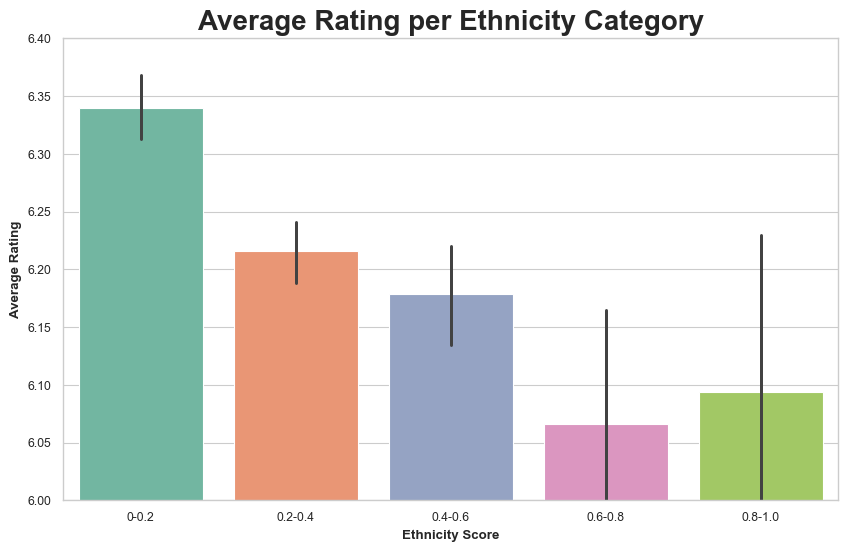

In [107]:
#define the categories
categories = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']

#categorize the ethnicity scores
movie_metadata_rating_ethnicity_df['ethnicity_category'] = pd.cut(movie_metadata_rating_ethnicity_df['ethnicity_score'], 
                                                                 bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                                                                 labels=categories)

#plot the average rating per ethnicity category
plt.figure(figsize=(10, 6))
sns.barplot(x='ethnicity_category', 
            y='averageRating', 
            data=movie_metadata_rating_ethnicity_df, 
            errorbar=('ci', 95))

plt.xlabel('Ethnicity Score')
plt.ylabel('Average Rating')
plt.ylim(6, 6.4)
plt.title('Average Rating per Ethnicity Category')
plt.show()

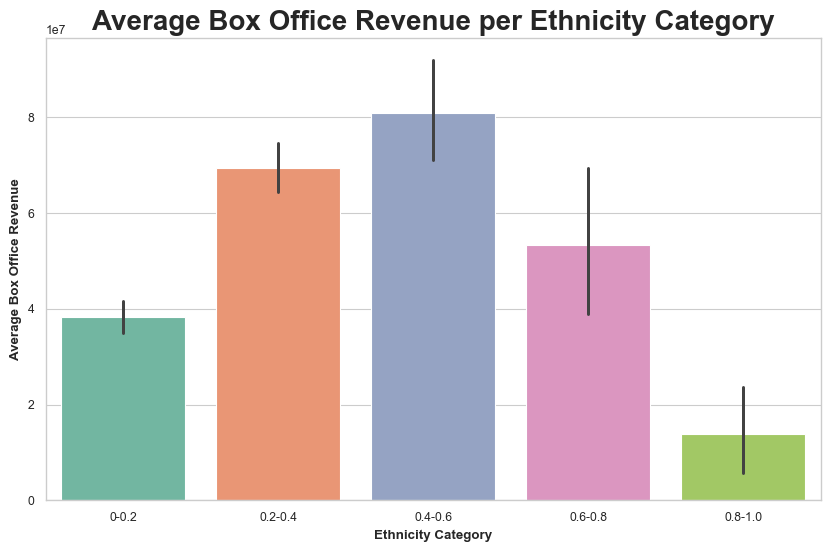

In [108]:
#plot the average box office revenue per ethnicity category
plt.figure(figsize=(10, 6))
sns.barplot(x='ethnicity_category', 
            y='movie_box_office_revenue', 
            data=movie_metadata_rating_ethnicity_df, 
            errorbar=('ci', 95))

plt.xlabel('Ethnicity Category')
plt.ylabel('Average Box Office Revenue')
plt.title('Average Box Office Revenue per Ethnicity Category')
plt.show()


#### **Ethnicity uniform distribution analysis**

We are now going to analyze the ethnicity in a difference way. We are going to associate a score to the **uniformness of the distribution** of the ethnicities in a movie. For this we are going to use the **entropy** of the distribution (Shannon Diversity Index).

In [109]:
#extract the actor ethnicity into a Series from the character metadata removing duplicates
actor_ethnicity_df = \
    character_metadata_df["actor_ethnicity"].drop_duplicates().dropna().reset_index(drop=True)

We define the `ethnicities_names_df` dataframe, containing the names of the ethnicities for each ethnicity id.

In [110]:
#create a dataframe from the results of the sparql query from every element in actor_ethnicity_series
ethnicities_name_filename = 'data/RESULTS/ethnicities_name.csv'

if os.path.exists(ethnicities_name_filename):
    ethnicities_name_df = pd.read_csv(ethnicities_name_filename)
else:
    ethnicity_queried_values = [get_wikidata_id(value) for value in actor_ethnicity_df]
    ethnicities_name_df = \
        pd.DataFrame({'ethnicity_id': actor_ethnicity_df,
                      'ethnicity_name': ethnicity_queried_values})
    # save to csv
    ethnicities_name_df.to_csv(ethnicities_name_filename, index=False)

In [111]:
# merge character_metadata_df with df on actor_ethnicity and ethnicity_name
character_metadata_df = pd.merge(character_metadata_df, 
                                 ethnicities_name_df, 
                                 left_on='actor_ethnicity', 
                                 right_on='ethnicity_id', 
                                 how='left')

character_metadata_df.drop(columns=["ethnicity_id"], inplace=True)
character_metadata_df.rename(columns={'actor_ethnicity': 'actor_ethnicity_id', 
                                      'ethnicity_name':'actor_ethnicity'}, 
                                      inplace=True)
character_metadata_df.sample(5)

,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,movie_release_year,actor_ethnicity
175459,213188,/m/01f73r,1990-08-03,NaN,1935-07-29,F,1.65,NaN,Joan Gerber,55.0,/m/0chcx6s,NaN,/m/0270dsb,1990.0,NaN
49321,4718224,/m/0cjx6q,1988-10-07,John Krytsick,1952-06-20,M,1.88,/m/07hwkr,John Goodman,36.0,/m/02vbm51,/m/0h03fzc,/m/01nm3s,1988.0,White Americans
50048,25073384,/m/09g8c5y,2010-10-05,Mitch Saunders,NaN,M,NaN,NaN,Stephen Dervan,NaN,/m/0gdf0h_,/m/0gdf0j2,/m/0gdf0j9,2010.0,NaN
23261,17046277,/m/047gmx9,1972,NaN,NaN,NaN,NaN,NaN,Lawrence Wolf,NaN,/m/09krv20,NaN,/m/09krtzh,1972.0,NaN
177841,448181,/m/029nc8,2004,Rosedale Princess,1982-10-12,F,1.66,NaN,Sarah Smyth,21.0,/m/0gkmdxt,/m/0gkmdxw,/m/0f8vdj,2004.0,NaN


We define the `character_metadata_encoded_df` dataframe, containing the **one-hot encoding** of each ethnicity and the `wiki_movie_id`.

In [112]:
# drop na values from the actor_ethnicity column
character_metadata_df = character_metadata_df.dropna(subset=['actor_ethnicity'])

#only keep wiki_movie_id and actor_ethnicity columns
character_metadata_encoded_df = character_metadata_df[['wiki_movie_id', 'actor_ethnicity']]

# Perform one-hot encoding on the actor_ethnicity column
character_metadata_encoded_df = pd.get_dummies(character_metadata_encoded_df, columns=['actor_ethnicity'])

character_metadata_encoded_df.sample(5)

,wiki_movie_id,actor_ethnicity_Acadians,actor_ethnicity_Afghans in India,actor_ethnicity_African Americans,actor_ethnicity_African people,actor_ethnicity_Afro Trinidadians and Tobagonians,actor_ethnicity_Afro-Asians,actor_ethnicity_Afro-Cuban,actor_ethnicity_Afro-Guyanese,actor_ethnicity_Agrawal,...,actor_ethnicity_Xhosa people,actor_ethnicity_Yoruba people,actor_ethnicity_Yugoslavs,actor_ethnicity_culture of Palestine,actor_ethnicity_history of the Jews in the African diaspora,actor_ethnicity_multiracial people,actor_ethnicity_names of the Greeks,actor_ethnicity_peoples of the Caucasus,actor_ethnicity_rajput,actor_ethnicity_white people
65104,4876364,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
156736,15445885,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
164614,10224734,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
87754,1295310,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
108678,25698427,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [113]:
#compute the number of actors for each ethnicity for each movie
movie_ethnicity_enconded_df = character_metadata_encoded_df.groupby('wiki_movie_id').sum()

movie_ethnicity_enconded_df.sample(5)

,actor_ethnicity_Acadians,actor_ethnicity_Afghans in India,actor_ethnicity_African Americans,actor_ethnicity_African people,actor_ethnicity_Afro Trinidadians and Tobagonians,actor_ethnicity_Afro-Asians,actor_ethnicity_Afro-Cuban,actor_ethnicity_Afro-Guyanese,actor_ethnicity_Agrawal,actor_ethnicity_Akan people,...,actor_ethnicity_Xhosa people,actor_ethnicity_Yoruba people,actor_ethnicity_Yugoslavs,actor_ethnicity_culture of Palestine,actor_ethnicity_history of the Jews in the African diaspora,actor_ethnicity_multiracial people,actor_ethnicity_names of the Greeks,actor_ethnicity_peoples of the Caucasus,actor_ethnicity_rajput,actor_ethnicity_white people
wiki_movie_id,,,,,,,,,,,,,,,,,,,,,
3303226,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7357270,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19167990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
163500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24863901,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [114]:
#apply the shannon entropy function to the grouped_df
movie_ethnicity_sdi_df = movie_ethnicity_enconded_df.apply(lambda x: SDI(x), axis=1)

#merge the grouped_df_sdi with the movie_metadata_rating_df
movie_metadata_rating_df = pd.merge(movie_metadata_rating_df, 
                                    movie_ethnicity_sdi_df.rename('SDI'), 
                                    on='wiki_movie_id', 
                                    how='left')

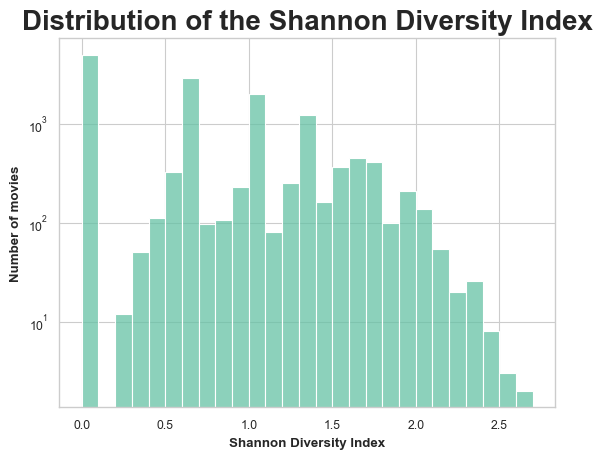

In [115]:
#plot the distribution of the SDI
sns.histplot(movie_ethnicity_sdi_df, 
             stat="count", 
             log_scale=(False, True), 
             kde=False, 
             binwidth=0.1)

plt.xlabel("Shannon Diversity Index")
plt.ylabel("Number of movies")
plt.title("Distribution of the Shannon Diversity Index")
plt.show()

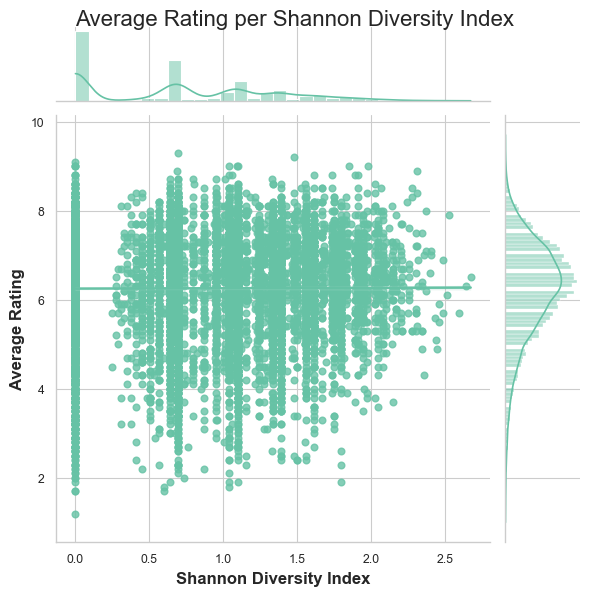

In [116]:
# Create a joint plot with on x-axis
g = sns.jointplot(x='SDI', 
                  y='averageRating', 
                  data=movie_metadata_rating_df, 
                  kind='reg')

# Set the axis labels and title
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Average Rating per Shannon Diversity Index', fontsize=16)
g.set_axis_labels('Shannon Diversity Index', 'Average Rating', fontsize=12)
plt.show()

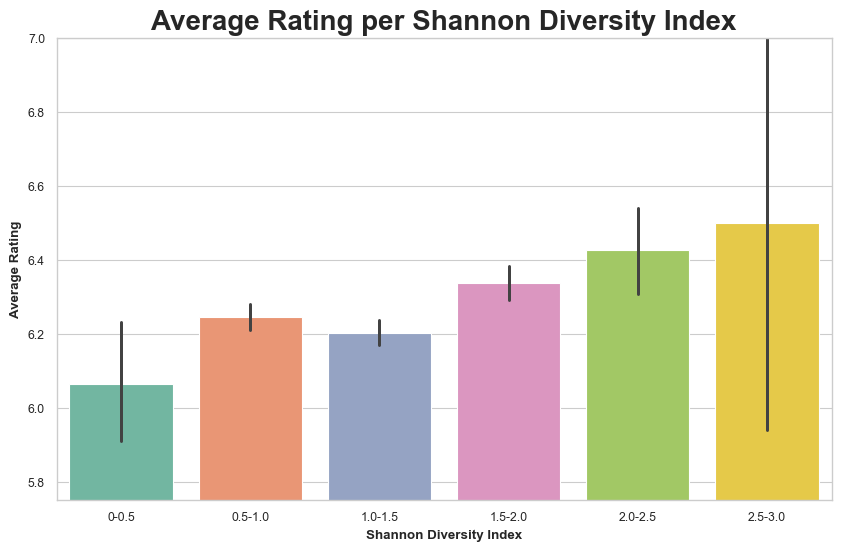

In [117]:
#define the categories
categories = ['0-0.5', '0.5-1.0', '1.0-1.5', '1.5-2.0', '2.0-2.5', '2.5-3.0']

movie_metadata_revenue_sdi_df = movie_metadata_rating_df[['wiki_movie_id', 
                                                          'averageRating', 
                                                          'movie_box_office_revenue', 
                                                          'SDI']]

#categorize the SDI values
movie_metadata_revenue_sdi_df['SDI_category'] = pd.cut(movie_metadata_revenue_sdi_df['SDI'], 
                                                  bins=[0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], 
                                                  labels=categories)

#plot the average rating per SDI category
plt.figure(figsize=(10, 6))
sns.barplot(x='SDI_category', 
            y='averageRating', 
            data=movie_metadata_revenue_sdi_df, 
            errorbar=('ci', 95))

plt.xlabel('Shannon Diversity Index')
plt.ylim(5.75, 7)
plt.ylabel('Average Rating')
plt.title('Average Rating per Shannon Diversity Index')
plt.show()

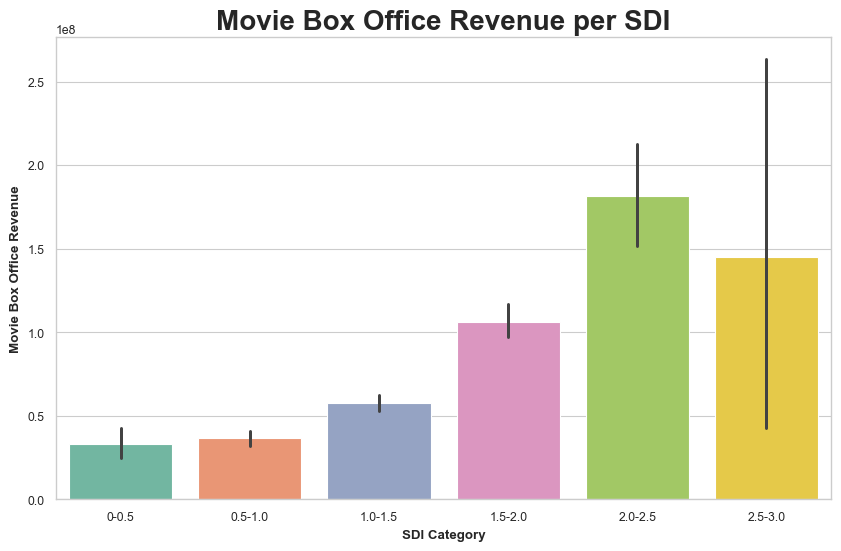

In [118]:
#plot the average rating per SDI category
plt.figure(figsize=(10, 6))
sns.barplot(x='SDI_category', 
            y='movie_box_office_revenue', 
            data=movie_metadata_revenue_sdi_df, 
            errorbar=('ci', 95))

plt.xlabel('SDI Category')
plt.ylabel('Movie Box Office Revenue')
plt.title('Movie Box Office Revenue per SDI')
plt.show()

In [119]:
#sample the movie_metadata_rating_df
movie_ethnicity_score_df = movie_metadata_rating_df[['wiki_movie_id', 'SDI', 'averageRating']]
movie_ethnicity_score_df.dropna(inplace=True)
movie_ethnicity_score_df.head(10)

,wiki_movie_id,SDI,averageRating
0,975900,0.636514,4.9
6,171005,0.950271,7.5
7,77856,0.636514,7.8
10,21926710,0.000000,6.1
13,156558,0.000000,6.4
15,9633533,0.867563,7.9
20,26067101,0.000000,6.4
22,25960460,1.332179,5.6
24,12008535,0.693147,6.7
25,4951456,1.098612,5.5


In [120]:
# split the dataframe into two based on SDI value
movie_ethnicity_score_df_under_half = \
    movie_ethnicity_score_df[movie_ethnicity_score_df['SDI'] < 1.75]
movie_ethnicity_score_df_over_half = \
    movie_ethnicity_score_df[movie_ethnicity_score_df['SDI'] >= 1.75]

#perform a t-test on the average rating of movies with an SDI score over and under the threshold
t_statistic, p_value = stats.ttest_ind(movie_ethnicity_score_df_over_half['averageRating'], 
                                       movie_ethnicity_score_df_under_half['averageRating'])

print("p-value:", p_value)

p-value: 0.0008825989100480101


In [121]:
#perform an ols regression for the Shannon Diversity Index per movie
mod = smf.ols(formula='averageRating ~ SDI',
              data=movie_ethnicity_score_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3580
Date:                Fri, 22 Dec 2023   Prob (F-statistic):              0.550
Time:                        22:51:47   Log-Likelihood:                -21874.
No. Observations:               14778   AIC:                         4.375e+04
Df Residuals:                   14776   BIC:                         4.377e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.2493      0.013    470.205      0.0

## **10. Evaluate the Effect of Gender Proportion in a Movie on the IMDb Rating**

We are now going to analyze the effect of **gender proportion** (parity) in a movie on the IMDb rating. To do so we are going to define a parity value for each movie containing the percentage of female actors in the movie.

In [122]:
movie_metadata_parity_df = \
    movie_metadata_rating_df[['wiki_movie_id', 'averageRating']]

In [123]:
character_gender_df = character_metadata_df[['wiki_movie_id', 'actor_gender']]
character_gender_df.dropna(inplace=True)

print("Size of character_gender_df:", character_gender_df.size)
character_gender_df.sample(5)

Size of character_gender_df: 101670


,wiki_movie_id,actor_gender
52886,6025381,M
290,1072373,M
144215,5671546,M
24527,1703740,M
171086,25080984,M


In [124]:
#count the number of male and female actors per movie
gender_counts_df = \
    character_gender_df.groupby('wiki_movie_id')['actor_gender'].value_counts().unstack()

#replace NaN with 0
gender_counts_df = gender_counts_df.fillna(0)

#compute the parity in actor gender
gender_parity_df = gender_counts_df['F'] / gender_counts_df.sum(axis=1) * 100

movie_metadata_parity_df = pd.merge(movie_metadata_rating_df, 
                                    gender_parity_df.rename('parity'), 
                                    left_on='wiki_movie_id', 
                                    right_index=True, 
                                    how='inner')

print("Size of movie_metadata_rating_df:", movie_metadata_rating_df.shape)
movie_metadata_parity_df.sample(5)

Size of movie_metadata_rating_df: (39963, 15)


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,tconst,averageRating,numVotes,titleType,SDI,parity
12027,37373877,/m/02vr316,Crazy Eights,2006-10-31,NaN,80.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01q03"": ""Cult"", ""/m/03npn"": ""Horror""}",2006.0,tt0470993,3.8,3337,movie,0.693147,100.000000
874,14291637,/m/03c_lhp,Fool's Gold,2008-02-07,111231041.0,112.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03k9fj"": ""...",2008.0,tt0770752,5.7,83237,movie,1.747868,28.571429
9731,924954,/m/03qfyt,The Heroes of Telemark,1965-11,NaN,131.0,"{""/m/05f_3"": ""Norwegian Language"", ""/m/02h40lc...","{""/m/07ssc"": ""United Kingdom""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/02kdv5l...",1965.0,tt0059263,6.5,7844,movie,0.693147,0.000000
21241,33025020,/m/0fpmrmq,Pariah,2011-01-20,758099.0,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011.0,tt1233334,7.2,7423,movie,0.000000,75.000000
24097,2056466,/m/06j0d5,The Animal,2001,84772742.0,83.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",2001.0,tt0255798,4.8,62625,movie,1.386294,0.000000


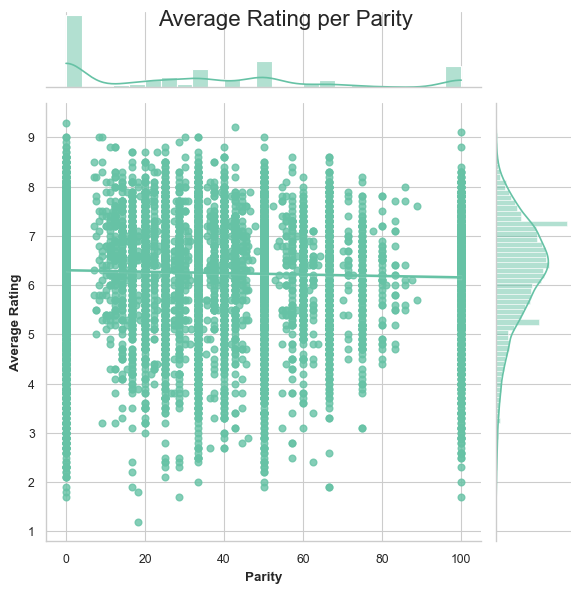

In [125]:
#plot the joint plot of parity and average rating
g = sns.jointplot(x='parity', 
                  y='averageRating', 
                  data=movie_metadata_parity_df,
                  kind='reg')

#set the axis labels and title
g.set_axis_labels('Parity', 'Average Rating')
g.fig.suptitle('Average Rating per Parity', fontsize=16)
plt.show()

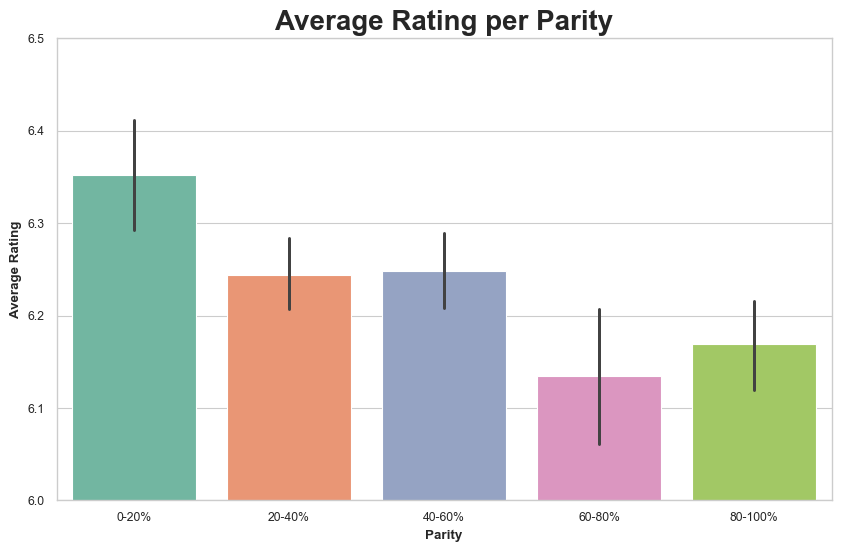

In [126]:
#define the categories
categories = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']

movie_metadata_revenue_parity_df = movie_metadata_parity_df[['wiki_movie_id', 
                                                          'averageRating', 
                                                          'movie_box_office_revenue', 
                                                          'parity']]

#categorize the parity values
movie_metadata_revenue_parity_df['parity_category'] = pd.cut(movie_metadata_revenue_parity_df['parity'], 
                                                     bins=[0, 20, 40, 60, 80, 100], 
                                                     labels=categories)

#plot the average rating per parity category
plt.figure(figsize=(10, 6))
sns.barplot(x='parity_category', 
            y='averageRating', 
            data=movie_metadata_revenue_parity_df, 
            errorbar=('ci', 95))

plt.xlabel('Parity')
plt.ylabel('Average Rating')
plt.ylim(6, 6.5)
plt.title('Average Rating per Parity')
plt.show()

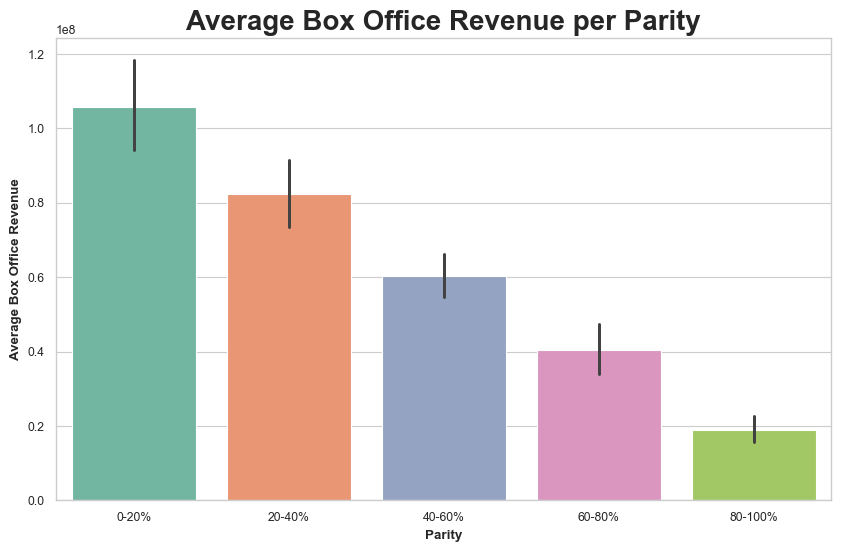

In [127]:
#categorize the parity values
movie_metadata_revenue_parity_df['parity_category'] = pd.cut(movie_metadata_revenue_parity_df['parity'], 
                                                     bins=[0, 20, 40, 60, 80, 100], 
                                                     labels=categories)

#plot the average box office revenue per parity category
plt.figure(figsize=(10, 6))
sns.barplot(x='parity_category', 
            y='movie_box_office_revenue', 
            data=movie_metadata_revenue_parity_df, 
            errorbar=('ci', 95))

plt.xlabel('Parity')
plt.ylabel('Average Box Office Revenue')
plt.title('Average Box Office Revenue per Parity')
plt.show()

In [128]:
# split the dataframe into two based on parity value
movie_parity_score_df_under_half = \
    movie_metadata_revenue_parity_df[movie_metadata_revenue_parity_df['parity'] < 50]
movie_parity_score_df_over_half = \
    movie_metadata_revenue_parity_df[movie_metadata_revenue_parity_df['parity'] >= 50]

# perform t-test for parity
t_statistic_parity, p_value_parity = stats.ttest_ind(movie_parity_score_df_over_half['averageRating'], 
                                                     movie_parity_score_df_under_half['averageRating'])

print("p-value for parity:", p_value_parity)

p-value for parity: 3.7678560274879865e-06


In [129]:
#perform an ols regression for parity
mod = smf.ols(formula='averageRating ~ parity',
              data=movie_metadata_revenue_parity_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     29.43
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           5.90e-08
Time:                        22:51:52   Log-Likelihood:                -21844.
No. Observations:               14769   AIC:                         4.369e+04
Df Residuals:                   14767   BIC:                         4.371e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3023      0.012    514.571      0.0

## **11. Evaluate the Effect of Movie Genre on the IMDb Rating**

### **Genre over time**

In [160]:
df = movie_metadata_rating_df.copy().set_index('wiki_movie_id')

year_range = range(1930, 2020,10)
data = {}

for year in year_range:
    genre_counts = filter_by_year(df, year-1, year+1)  # +/-1 year for a range
    data[year] = genre_counts

fig = ps.make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=data[1930].index, y=data[1930].values, name='Genres'), secondary_y=False)


sliders = [
    {
        'active': 0,
        'currentvalue': {"prefix": "Year: "},
        'pad': {"t": 50},
        'steps': [
            {
                'label': str(year),
                'method': 'update',
                'args': [{'x': [data[year].index], 'y': [data[year].values]}]
            } for year in year_range
        ]
    }
]

fig.update_layout(sliders=sliders)

fig.update_layout(title="Genre Popularity Over Years")

fig.show()

### **Genre regression**

We define the `movie_genres_df` dataframe, which contains the genres of movies. We construct this dataframe by reading the `movie_genres` column from the `movie_metadata_ratings_df` dataframe. This column contains a dictionary of genre_id and genre_name. We then extract the genre_name and add it to the a new column called `movie_genres`.

In [131]:
#create a dataframe with only the movie genres
movie_genres_df = movie_metadata_rating_df[['freebase_movie_id', 'movie_genres']]
movie_genres_df['movie_genres'] = movie_metadata_rating_df['movie_genres'].apply(transform_genres_string)
genres_df = movie_genres_df['movie_genres']
genres_df.sample(5)

12980    {'/m/0vgkd': 'Black comedy', '/m/07s9rl0': 'Dr...
16286                              {'/m/07s9rl0': 'Drama'}
11884      {'/m/02kdv5l': 'Action', '/m/07s9rl0': 'Drama'}
29488    {'/m/02l7c8': 'Romance Film', '/m/07s9rl0': 'D...
32987    {'/m/02l7c8': 'Romance Film', '/m/07s9rl0': 'D...
Name: movie_genres, dtype: object

In [132]:
THRESHOLD = 100
genres_filtered_df = filter_genres(genres_df, 1000, True)
dummy_variables_df = get_genre_dummies(genres_filtered_df)
genres_df = dummy_variables_df.merge(movie_metadata_rating_df['averageRating'], 
                                     left_index=True,
                                     right_index= True,
                                     how='left').copy()

X_column_names = [col for col in genres_df.columns if col != 'averageRating']
y_column_names = ['averageRating']
model_genres, mae = linear_regression(X_column_names, y_column_names, genres_df)
print("Mean absolute error of linear regression on genres:", mae)

Mean absolute error of linear regression on genres: 0.7563669684996784


### **Predicting Movie rating soleley on genre information**

Running linear regression with a 0.8/0.2 or 0.85/0.15 train/test split, we get a mean absolute error of 0.72 for a threshold of 750 (meaning genres with less than 750 representatives aaren't represented), we coul use a stricter or more loosse threshold, the result doesn't change all that much. It would be interresting to if the time when the film went out plays a role in the films' sucess.

In [133]:
show_model(model_genres)

How certain can we be of our guess, when predicting on genres? Data shows, that it doesn't purely depend on the genre in question (cf model results and p-values of different coefficients, represented on this graph) but also on the year in question. Running linear regression on data grouped by yars, we can see a steady risse in error, indicating more unceartainty present in recent years. A logical observation would be to account for more recent films in our data in addition to older films haven gone through the proof of time.

or someething like: as we can see, the uncertainty grows with the years. First of all, we have to remember that our data has more releses closer to the present. Logically, the films that "stood the test of time" and found their way into the dataset are more likely to be of better quality, since they have not been forgotten, while the modern creations find their way into lists without any paticular trrouble.

### **Looking at errors when training and testing on the same year**

In [134]:
years = list(range(1930, 2020, 5))
errors = []
for year in years:
    df = movie_metadata_rating_df.copy()
    filt_metadata_df = df[movie_metadata_rating_df['movie_release_year'] < year]
    filt_metadata_df = filt_metadata_df[filt_metadata_df['movie_release_year'] >= year-5]
    errors.append(full_genre_process(filt_metadata_df, 100)[1])

fig = go.Figure(data=go.Scatter(x=years, y=errors, mode='lines+markers'))
fig.update_layout(title='Linear Regression Mean Absolute Error for a given 5 year period',
                  xaxis_title='Years',
                  yaxis_title='Mean Absolute Error')
fig.show()

In [135]:
# Plot 1: Average Rating per Year (Line Plot)
df = movie_metadata_rating_df[movie_metadata_rating_df['movie_release_year'] > 1920].copy()
df = df.groupby('movie_release_year')['averageRating'].mean().reset_index()

# Create a line trace for "Average Rating per Year"
line_trace = go.Scatter(
    x=df['movie_release_year'],
    y=df['averageRating'],
    mode='lines',
    name='Average Rating',
    line=dict(color='blue'),  # Customize line color
)

# Create a layout
layout = go.Layout(
    title='Average Rating per Year',
    xaxis=dict(title='Years'),
    yaxis=dict(title='Average Rating'),
)
fig1 = go.Figure(data=[line_trace], layout=layout)
fig1.update_xaxes(title_text='Years')
fig1.update_yaxes(title_text='Average Rating')

# Plot 2: Distribution of Top 1000 Movies by Year (Histogram)
df_top_1000 = movie_metadata_rating_df.sort_values(by='averageRating', ascending=False).head(1000)
fig2 = px.histogram(df_top_1000, x='movie_release_year', nbins=10, title='Distribution of Top 1000 Movies by Year')
fig2.update_xaxes(title_text='Years')
fig2.update_yaxes(title_text='Counts')

# Create a subplot with two plots vertically
fig = ps.make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=2, col=1)

# Update layout and titles
fig.update_layout(height=600, title_text="Average Ratings per year vs Top 1000 Movie Distribution Over Years")

# Show the plot
fig.show()

### **Where them good fims at?**

A as we can see, the avarrage ratting of films seems to go down throughouut years, yet if we analise the top 1000 movies, we see that they are more likeley to be found in the recent years. Considering that the evaluation of movie genres wasn't quite sufficient, why not try gain more information on their "vibe" by analising the plots. Such analysis can be conducted with the aid of NLP tools, it is however important to reflect on what sort of information we want to use.

Having observed the different prrertrained models and their caapabilaties (as much as the capabilaties of our hardware), it seemed that an interesting aproach would be utilizing the zero-shot-classification capabilaty of DeBERTa-v3-base-mnli-fever-anli, a pretrained and fine-tuned model we found on hugging face. Given a text and a list of labels as input, the model assigns probabilaties to each of the labels (together summing to 1). Thus, an interesting aprroach would be to create multiple lists with emelements from similar groups and running thee model on all the texts and lists, get orer informattion about the time period described in the plot, a particular way the plot was constructed, what sort of problem is the story constructed around etc.

Since this is a computation heavy process, it was decided to only run in on parrt of our dataset, nameley films coming out after 1980 and having more than 1000 votes. This still gave us 9900 samples to work with.

In [136]:
metadata_df = movie_metadata_rating_df.set_index('wiki_movie_id')
metadata_df = metadata_df[metadata_df['movie_release_year'] > 1980].copy()
metadata_df = metadata_df[metadata_df['numVotes'] > 1000].copy()

In [137]:
rating_labels = create_labels_df(threshold = 0.4, path_to_file = 'data/DeBERTa-v3/complete_De-BERTa_plots.csv')
rating_labels, labels = filter_labels(rating_labels,10,600)
print("Number of labels left after filtering:", len(labels))
print("Rating labels shape:", rating_labels.shape)

Number of labels left after filtering: 151
Rating labels shape: (8161,)


In [138]:
show_label_counts(rating_labels, 20)

In [139]:
labels_rattings_df = \
    pd.DataFrame(rating_labels).merge(metadata_df['averageRating'], 
                                      left_index=True, 
                                      right_index=True, 
                                      how='left').copy()

show_label_means(labels_rattings_df, 10)

Finaly, we perform a linear regression on the data

In [140]:
dummy_labels = get_label_dummies(rating_labels)
dummy_labels_rating = dummy_labels.merge(metadata_df['averageRating'], 
                                         left_index=True, 
                                         right_index=True, 
                                         how='left').copy()
model, mal = linear_regression(dummy_labels.columns,['averageRating'], dummy_labels_rating)
print("Mean absolute loss when doing linear regreession:", mal)

Mean absolute loss when doing linear regreession: 0.8172447844553768


We then check how will the same samples would compare if we try to predict soleley on their genre data

In [141]:
df = metadata_df.copy()
df = df.loc[rating_labels.index]
genre_model , genre_mal = full_genre_process(df, 100)
print("Mean absolute loss when doing linear regreession on genre column:", genre_mal)

Mean absolute loss when doing linear regreession on genre column: 0.7247300034084617


In [142]:
show_model(model)

As we can see, the confidence intervals are larger than in the case of genres and the most influentual labels are those that correlate the modst with a specific genre, however this is more information we can work with and it seems to be menaingful in one way or another. Now, it would be interesting to combine thhe knowledge we have on genres and labels together in order to get a more specialised model.

In [143]:
df = metadata_df['movie_genres'].copy().apply(lambda x: transform_genres_string(x))
df = df.loc[rating_labels.index]
df = get_genre_dummies(df)
df = df.merge(dummy_labels_rating, left_index=True, right_index=True, how='left')
combined_model, combined_mae = linear_regression(df.columns[:-1],['averageRating'], df)
print("Mean absolute loss when doing linear regreession on genre combined with labels:", combined_mae)

Mean absolute loss when doing linear regreession on genre combined with labels: 0.7233611978738222


In [144]:
show_model(combined_model)

## **12. IMDb Rating Prediction Model**

To conclude all of our analysis, we will now try to build a model that can **predict** the IMDb rating of a movie based on the features we have identified as important.

In [145]:
metadata_df = movies_metadata_ratings_df.copy()
metadata_df = metadata_df.drop_duplicates(subset=["wiki_movie_id"])
metadata_df = metadata_df.set_index("wiki_movie_id")
print("Size of metadata_df:", metadata_df.shape)

Size of metadata_df: (20161, 13)


### **Choose how to filter relevent/irrelevent information**

In [146]:
#define constants
LOWER_BOUND_TOPICS = 200
UPPER_BOUND_TOPICS = 5000
LOWER_BOUND_TOPIC_PROB = 0.7

LOWER_BOUND_GENRES = 500
UPPER_BOUND_GENRES = 10000

LOWER_BOUND_COUNTRIES = 500
UPPER_BOUND_COUNTRIES = 15000

LOWER_BOUND_LANGUAGES = 500
UPPER_BOUND_LANGUAGES = 10000

HISTORICAL_THRESHOLD = 0.77
HISTORICAL_LOWER_BOUND = 30
HISTORICAL_UPPER_BOUND = 5000

### **Load topics, transform into one-hot-encoding**

In [147]:
topics_df = pd.read_csv('data/DeBERTa-v3/complete_De-BERTa_plots.csv')
topics_df = topics_df.drop_duplicates(subset=['wiki_movie_id'])
topics_df = topics_df.set_index('wiki_movie_id')

topics_df = get_one_hot_encoded_df(topics_df, 
                                   'topics', 
                                   LOWER_BOUND_TOPICS,UPPER_BOUND_TOPICS)
topics_df[topics_df < LOWER_BOUND_TOPIC_PROB] = 0
topics_df.shape

(9890, 81)

In [148]:
genres_df = get_one_hot_encoded_df(metadata_df, 
                                   'movie_genres', 
                                   LOWER_BOUND_GENRES, 
                                   UPPER_BOUND_GENRES)

countries_df = get_one_hot_encoded_df(metadata_df, 
                                      'movie_countries', 
                                      LOWER_BOUND_COUNTRIES, 
                                      UPPER_BOUND_COUNTRIES, 
                                      rename_columns=True)

languages_df = get_one_hot_encoded_df(metadata_df,
                                      'movie_languages', 
                                      LOWER_BOUND_LANGUAGES, 
                                      UPPER_BOUND_LANGUAGES, 
                                      rename_columns=True)

In [149]:
historical_events_df = \
    pd.read_csv('data/RESULTS/linked_movies_and_events_df.csv')
historical_events_df = \
    historical_events_df.drop_duplicates(subset=['wiki_movie_id']).set_index('wiki_movie_id')
bin_historical_events_df = \
    historical_events_df[historical_events_df['similarity_score'] > HISTORICAL_THRESHOLD]['similarity_score']

historical_events_df = \
    historical_events_df.pivot( columns='matched_event', 
                               values='similarity_score')
historical_events_df = historical_events_df.fillna(0)
historical_events_df[historical_events_df < HISTORICAL_THRESHOLD] = 0
historical_events_df = filter_columns(historical_events_df, 
                                      HISTORICAL_LOWER_BOUND, 
                                      HISTORICAL_UPPER_BOUND)

historical_events_df = historical_events_df.merge(bin_historical_events_df, 
                                                  left_index=True, 
                                                  right_index=True)

print("Size of historical_events_df:", historical_events_df.shape)

Size of historical_events_df: (1270, 6)


In [150]:
metadata_df = get_metadata_subset(metadata_df)

additionnal_info_df = metadata_df[['movie_release_year','numVotes','averageRating']]
additionnal_info_df = additionnal_info_df.dropna()

df = topics_df.merge(genres_df, left_index=True, right_index=True, how='left')
df = df.merge(countries_df, left_index=True, right_index=True, how='left')
df = df.merge(languages_df, left_index=True, right_index=True, how='left')
df = df.merge(historical_events_df, left_index=True, right_index=True, how='left')
df = df.merge(additionnal_info_df, left_index=True, right_index=True, how='inner')

df.dropna()
df.fillna(0, inplace=True)

print("Size of df:", df.shape)

Size of df: (9890, 138)


In [151]:
model, loss_train, loss_test = regression.linear_regression(df.columns[:-1], 'averageRating', df)
print(f"Loss: {loss_train}, {loss_test}")

Loss: 0.6194468024416093, 0.6414122539338822


In [152]:
regression.show_model(model, 5, 0.8)

In [153]:
COEFICIENT_95_PERCENT_CI = 0.7

model_info = regression.filter_model_information(model, COEFICIENT_95_PERCENT_CI)
model_info = model_info[model_info['Key Word'] != 'Hindi Language']
model_info = model_info[model_info['Key Word'] != 'Documentary']

print("Size of model_info:", model_info.shape)

Size of model_info: (54, 7)


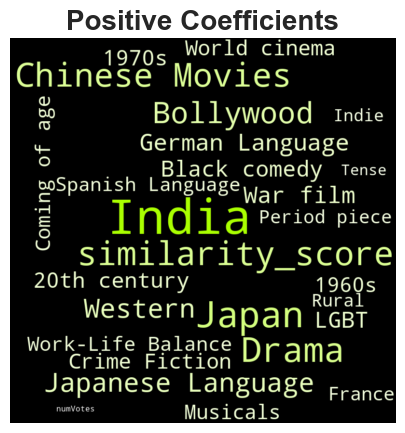

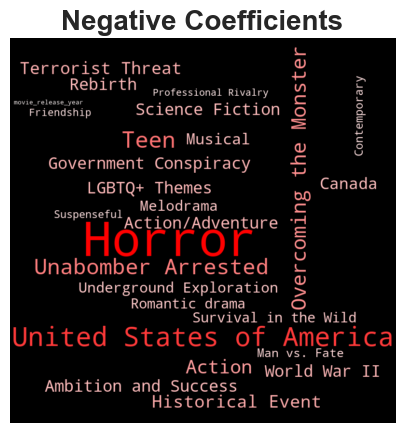

In [154]:
# Assuming you have a DataFrame named model_info with columns 'Key Word' and 'Coefficient'
# model_info = pd.DataFrame({'Key Word': ['word1', 'word2', ...], 'Coefficient': [0.5, -0.3, ...]})

# Separate keywords into positive and negative based on coefficients
positive_word_freq = {row['Key Word']: abs(row['Coefficient']) 
                      for _, row in model_info.iterrows() if row['Coefficient'] > 0}

negative_word_freq = {row['Key Word']: abs(row['Coefficient']) 
                      for _, row in model_info.iterrows() if row['Coefficient'] < 0}

regression.create_and_display_wordcloud(positive_word_freq, 80, "Positive Coefficients")
regression.create_and_display_wordcloud(negative_word_freq, 0, "Negative Coefficients")

#### **Rating prediction for the top 10 movies and the bottom 10 movies**

In [155]:
#predict the average rating of the top 10 movies
top_10_indexes = df.sort_values('averageRating', ascending=False).head(10).index.tolist()
top_10_normal = metadata_df.loc[top_10_indexes][['movie_name','averageRating']]
top_10_encoded = df[df.index.isin(top_10_indexes)]
X_test_top = sm.add_constant(top_10_encoded[df.columns[:-1]])
preds_top = model.predict(X_test_top)
#limit the predictions between 0 and 10
preds_top[preds_top > 10] = 10
preds_top[preds_top < 0] = 0
# Create a dataframe with the predicted rating and the real rating
predictions_top_df = pd.DataFrame({'Movie Name': top_10_normal['movie_name'],
                               'Predicted Rating': preds_top,
                               'Real Rating': top_10_normal['averageRating']})

predictions_top_df

,Movie Name,Predicted Rating,Real Rating
wiki_movie_id,,,
30625,The Shawshank Redemption,10.000000,9.3
65834,Schindler's List,10.000000,9.0
24542564,Om,6.340198,9.0
174251,The Lord of the Rings: The Return of the King,10.000000,9.0
19289204,Ashi Hi Banwa Banwi,7.231033,9.0
4276475,The Dark Knight,10.000000,9.0
14760023,Aha Naa Pellanta,7.307504,9.0
2172156,Kireedam,7.816860,8.9
54173,Pulp Fiction,10.000000,8.9


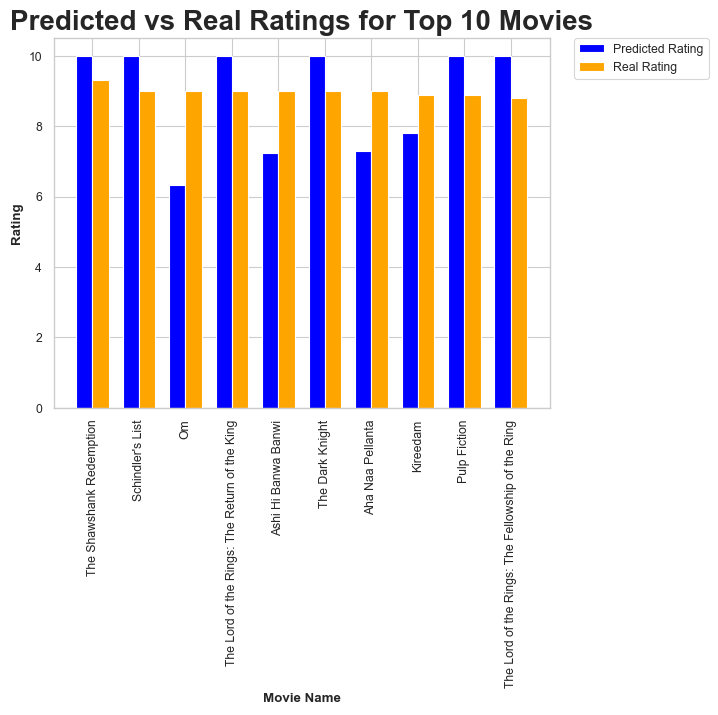

In [156]:
# Set the width of each bar
bar_width = 0.35

# Create the bar plot
plt.bar(np.arange(len(predictions_top_df)), 
        predictions_top_df['Predicted Rating'], 
        width=bar_width, 
        color='blue', 
        label='Predicted Rating')
plt.bar(np.arange(len(predictions_top_df)) + bar_width, 
        predictions_top_df['Real Rating'], 
        width=bar_width, 
        color='orange', 
        label='Real Rating')

plt.xlabel('Movie Name')
plt.ylabel('Rating')
plt.title('Predicted vs Real Ratings for Top 10 Movies')
plt.xticks(np.arange(len(predictions_top_df)) + bar_width/2, predictions_top_df['Movie Name'], rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [157]:
#predict the average rating of the bottom 10 movies
bottom_10_indexes = df.sort_values('averageRating', ascending=True).head(10).index.tolist()
bottom_10_normal = metadata_df.loc[bottom_10_indexes][['movie_name', 'averageRating']]
bottom_10_encoded = df[df.index.isin(bottom_10_indexes)]
X_test_bottom = sm.add_constant(bottom_10_encoded[df.columns[:-1]])
preds_bottom = model.predict(X_test_bottom)
#limit the predictions between 0 and 10
preds_bottom[preds_bottom > 10] = 10
preds_bottom[preds_bottom < 0] = 0
# Create a dataframe with the predicted rating and the real rating
predictions_bottom_df = pd.DataFrame({'Movie Name': bottom_10_normal['movie_name'],
                               'Predicted Rating': preds_bottom,
                               'Real Rating': bottom_10_normal['averageRating']})

predictions_bottom_df

,Movie Name,Predicted Rating,Real Rating
wiki_movie_id,,,
302757,From Justin to Kelly,5.222754,1.9
2523915,Going Overboard,5.579992,1.8
17726219,Disaster Movie,5.407539,1.9
20184221,Desh Drohi,6.305080,1.2
29587657,Justin Bieber: Never Say Never,6.132955,1.7
30332098,Universal Soldiers,5.152975,1.6
32044366,The Undefeated,6.045614,1.9
33462689,The Legend of the Titanic,6.185212,1.4
35587321,Alice in Murderland,5.006655,1.9


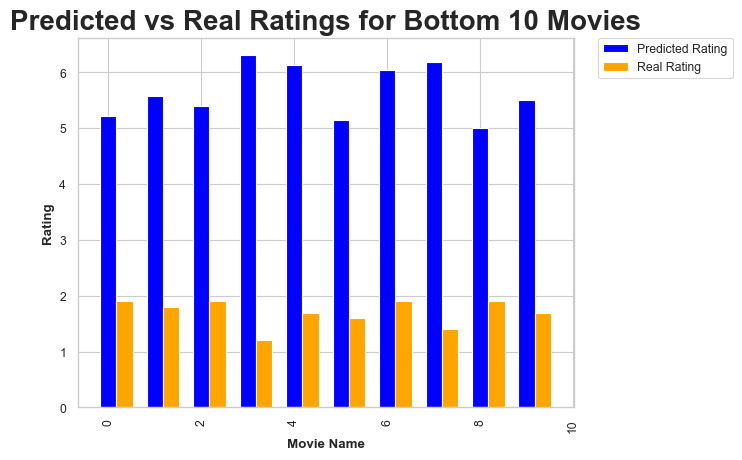

In [158]:
# Create the bar plot
plt.bar(np.arange(len(predictions_bottom_df)), 
        predictions_bottom_df['Predicted Rating'], 
        width=bar_width, 
        color='blue', 
        label='Predicted Rating')
plt.bar(np.arange(len(predictions_bottom_df)) + bar_width, 
        predictions_bottom_df['Real Rating'], 
        width=bar_width, 
        color='orange', 
        label='Real Rating')

plt.xlabel('Movie Name')
plt.ylabel('Rating')
plt.title('Predicted vs Real Ratings')
plt.xticks(rotation=90)
plt.title('Predicted vs Real Ratings for Bottom 10 Movies')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

We can see that our model is more efficient when predicting the rating of the top 10 movies than the bottom 10 movies. This is not an issue since we are more interested in predicting a top movie.